<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments</font></b>

# Introduction

## Contexte

Le projet se situe dans le cadre des efforts de la ville de Seattle pour atteindre son objectif de neutralité carbone d'ici 2050, un enjeu majeur dans la lutte contre le changement climatique. L'accent est mis sur l'analyse de la consommation énergétique et des émissions de dioxyde de carbone (CO2) des bâtiments non résidentiels, une composante significative de l'empreinte carbone de la ville. Pour cela, la ville dispose de données collectées en 2016, reflétant les consommations et émissions des bâtiments à cette période. Ces données, bien que précieuses, sont coûteuses et laborieuses à obtenir, d'où l'intérêt de développer un modèle prédictif capable d'estimer ces indicateurs pour les bâtiments non encore analysés, basé sur des caractéristiques structurelles telles que la taille, l'usage, la date de construction, ou encore la situation géographique des bâtiments.

## Objectifs

Tout d'abvord, réaliser une analyse exploratoire des données disponibles afin d'identifier les tendances, les anomalies et les relations potentielles entre les différentes variables. Et ensuite tester et comparer différents modèles de machine learning pour prédire avec précision la consommation totale d'énergie et les émissions de CO2 des bâtiments non résidentiels, sans données de consommation annuelle future, pour éviter toute fuite de données. Un intérêt particulier est porté à l'évaluation de l'utilité de l'"ENERGY STAR Score", un indicateur potentiellement pertinent mais complexe à calculer avec les méthodes actuelles. 

## Imports

In [169]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import Image

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Council District Map - 2024 - FULL.png',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'Pélec_01_EDA.ipynb',
 'Pélec_02_Modelisation.ipynb']

In [3]:
os.listdir("data/sources/")

['2016_Building_Energy_Benchmarking.csv']

In [4]:
path     = "./data/sources/"
filename = "2016_Building_Energy_Benchmarking.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exploration des données

## Quick tour

In [7]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [8]:
data.shape

(3376, 46)

In [9]:
data.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

In [10]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

In [11]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.85 %


In [13]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
OSEBuildingID                                               0   
DataYear                                                    0   
BuildingType                                                0   
PrimaryPropertyType                                         0   
PropertyName                                                0   
Address                                                     0   
City                                                        0   
State                                                       0   
ZipCode                                                    16   
TaxParcelIdentificationNumber                               0   
CouncilDistrictCode                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
YearBuilt                                                   0   
NumberofBuildings                                           8   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
PropertyGFABuilding(s)                                      0   
ListOfAllPropertyUseTypes                                   9   
LargestPropertyUseType                                     20   
LargestPropertyUseTypeGFA                                  20   
SecondLargestPropertyUseType                             1697   
SecondLargestPropertyUseTypeGFA                          1697   
ThirdLargestPropertyUseType                              2780   
ThirdLargestPropertyUseTypeGFA                           2780   
YearsENERGYSTARCertified                                 3257   
ENERGYSTARScore                                           843   
SiteEUI(kBtu/sf)                                            7   
SiteEUIWN(kBtu/sf)                                          6   
SourceEUI(kBtu/sf)                                          9   
SourceEUIWN(kBtu/sf)                                        9   
SiteEnergyUse(kBtu)                                         5   
SiteEnergyUseWN(kBtu)                                       6   
SteamUse(kBtu)                                              9   
Electricity(kWh)                                            9   
Electricity(kBtu)                                           9   
NaturalGas(therms)                                          9   
NaturalGas(kBtu)                                            9   
DefaultData                                                 0   
Comments                                                 3376   
ComplianceStatus                                            0   
Outlier                                                  3344   
TotalGHGEmissions                                           9   
GHGEmissionsIntensity                                       9   

                                 Pourcentage de valeurs manquantes  
OSEBuildingID                                                 0.00  
DataYear                                                      0.00  
BuildingType                                                  0.00  
PrimaryPropertyType                                           0.00  
PropertyName                                                  0.00  
Address                                                       0.00  
City                                                          0.00  
State                                                         0.00  
ZipCode                                                       0.47  
TaxParcelIdentificationNumber                                 0.00  
CouncilDistrictCode                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude  

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

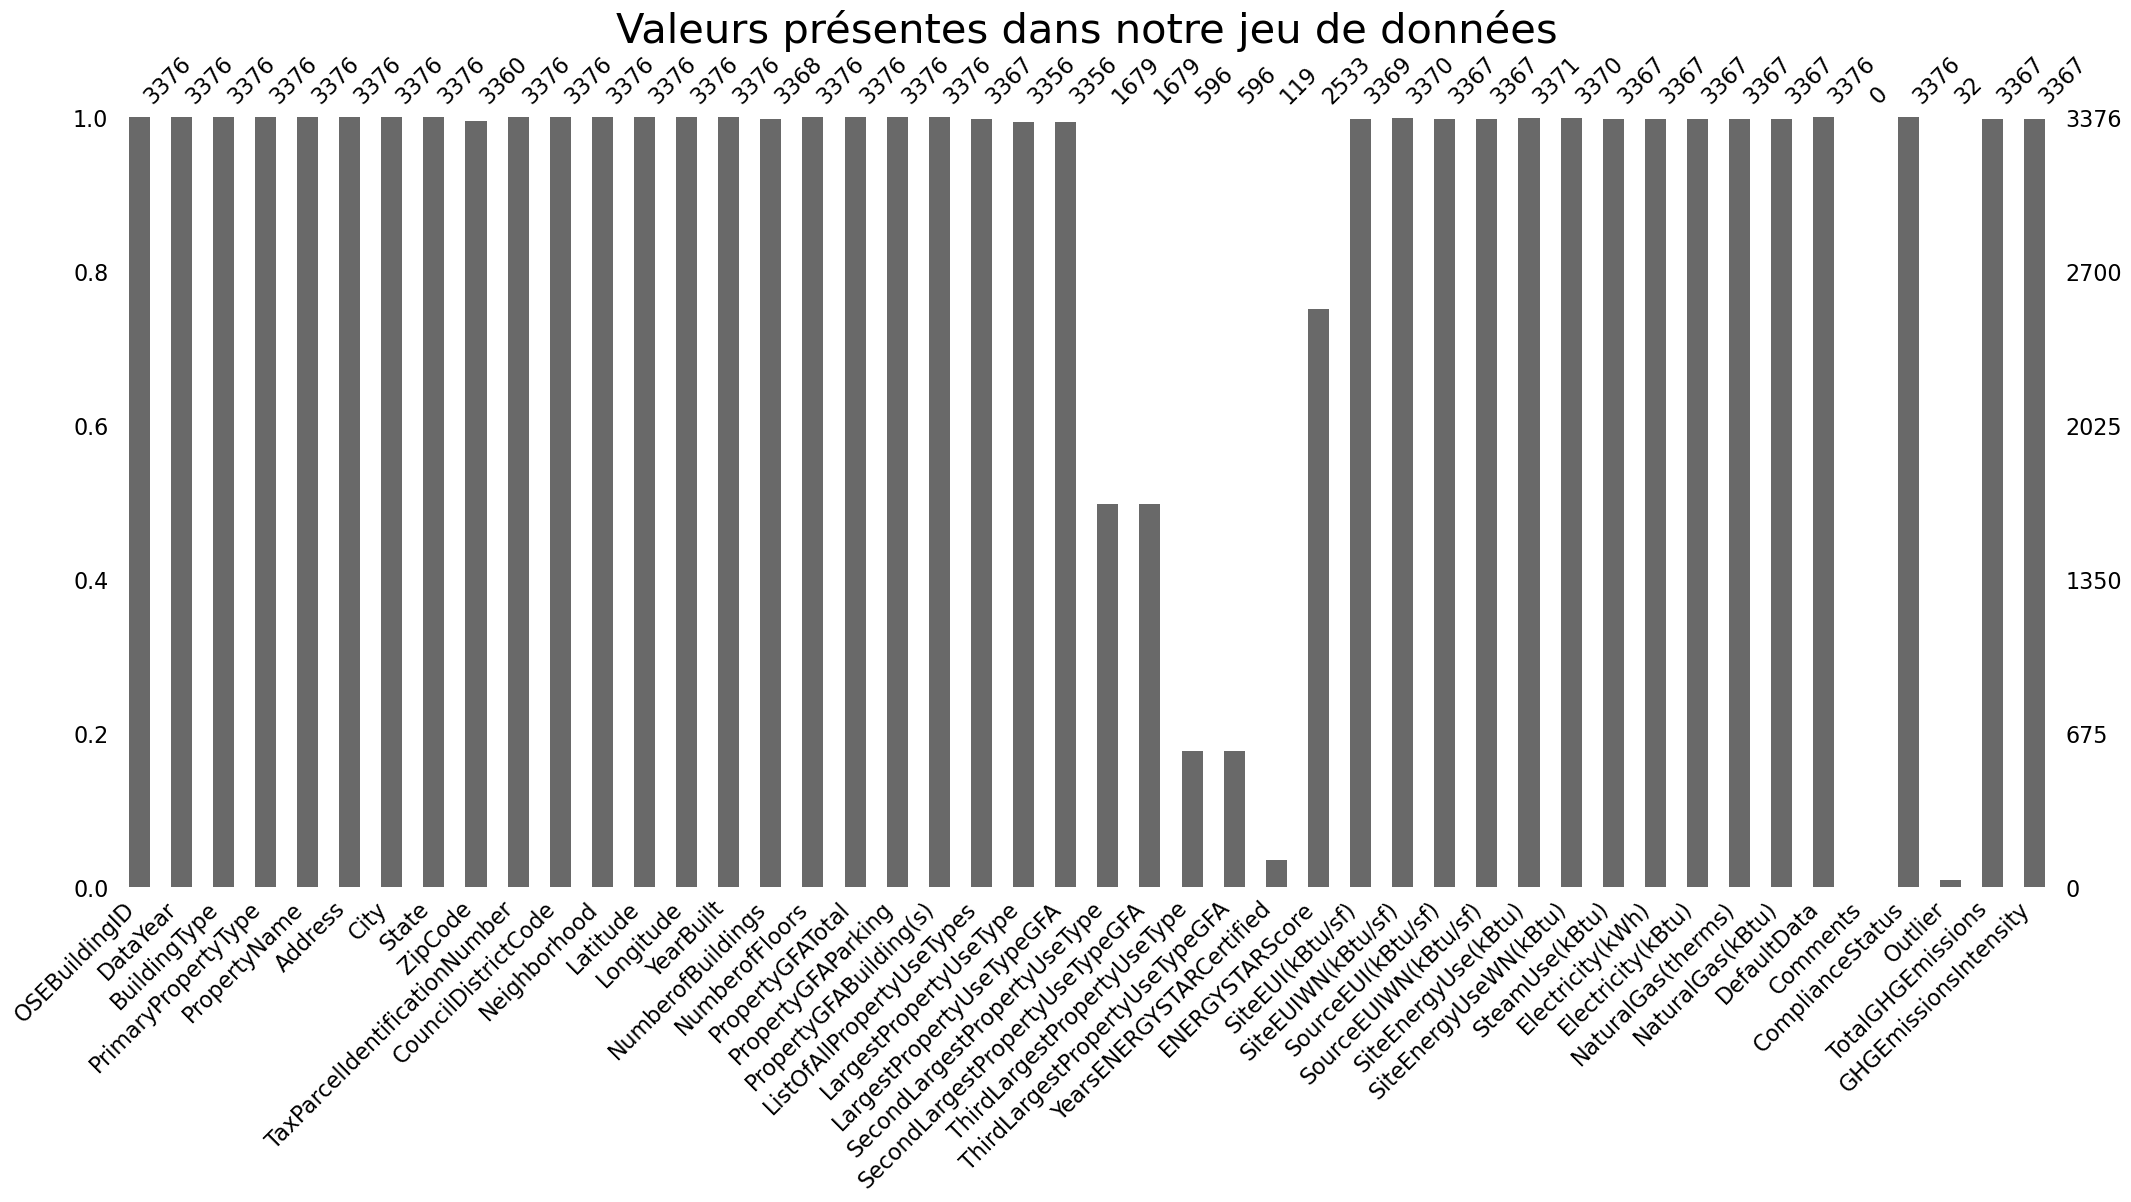

In [14]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

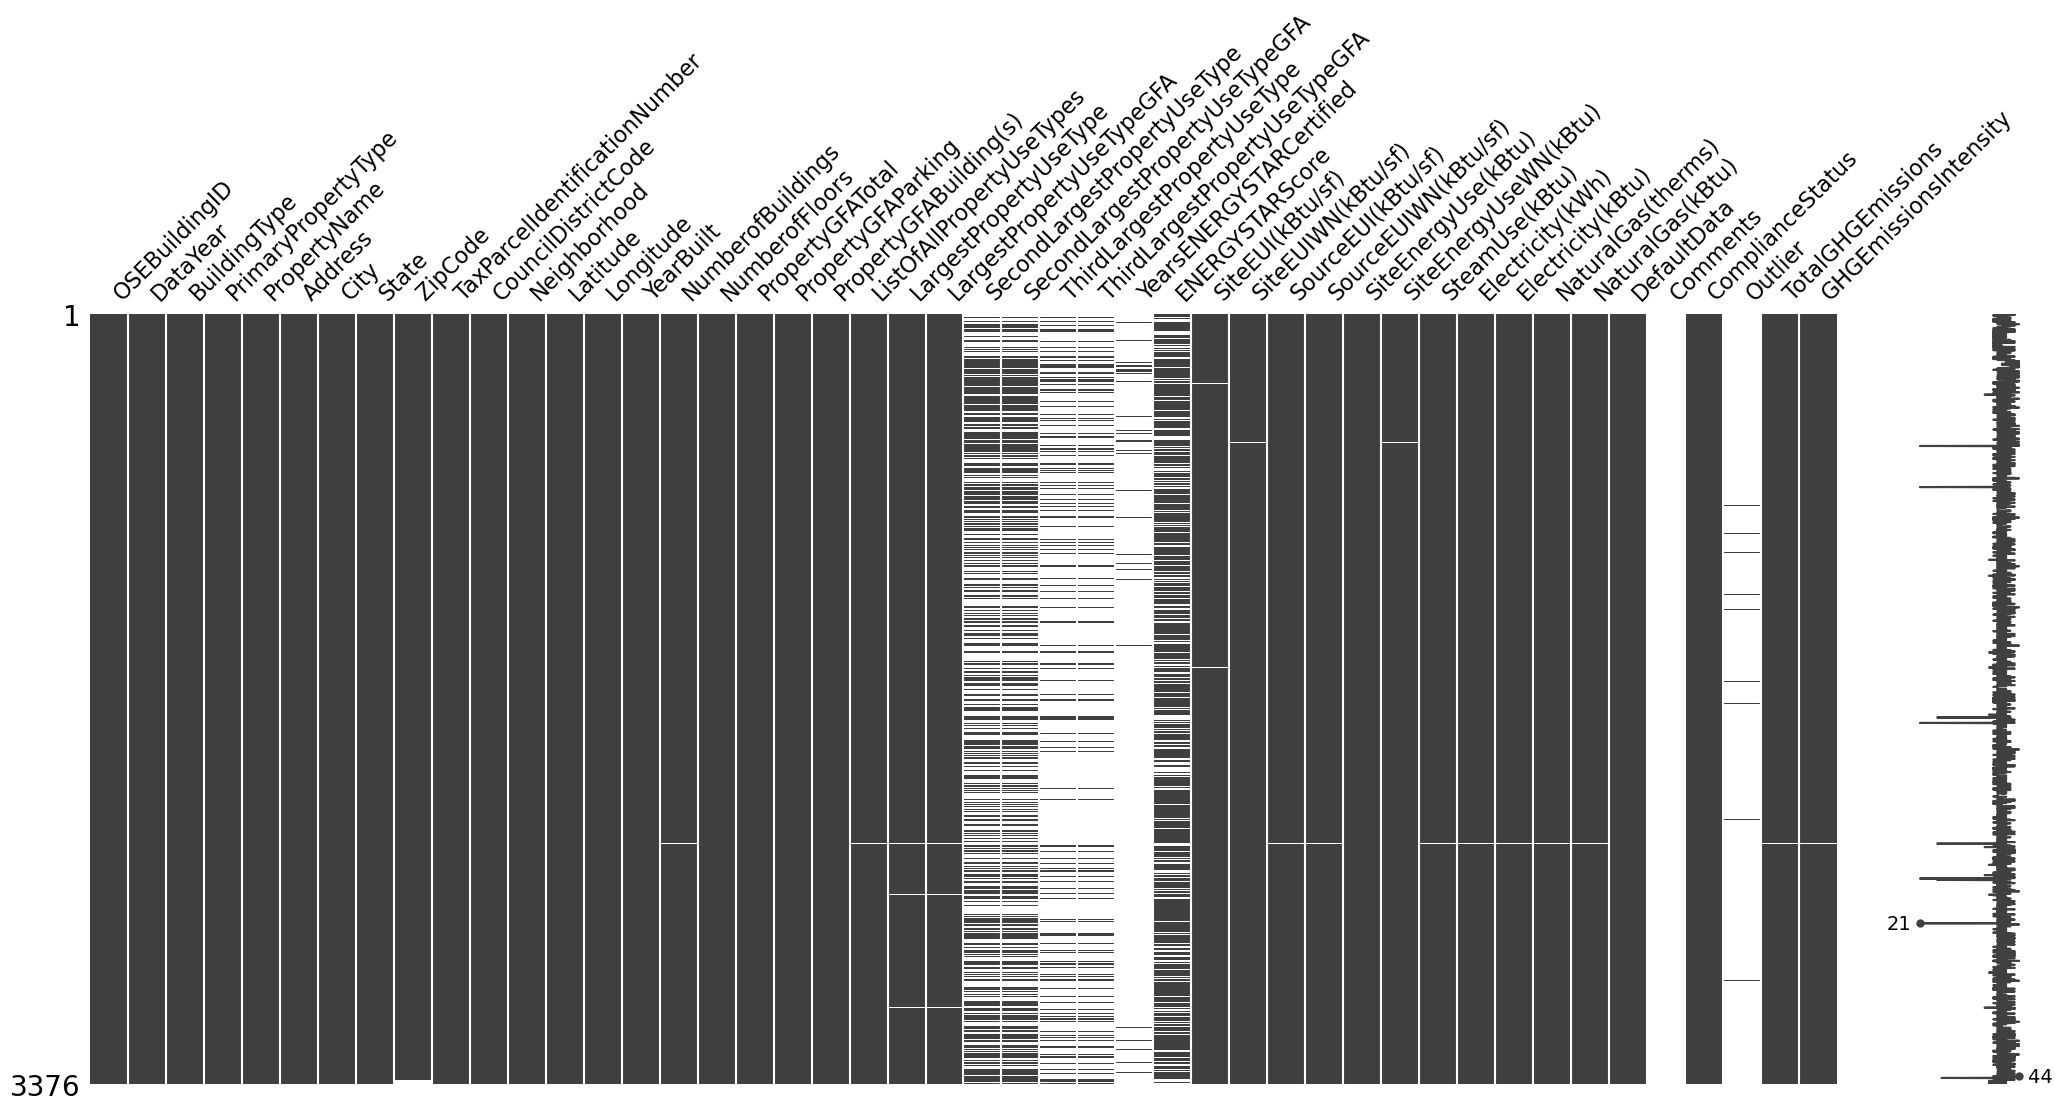

In [15]:
msno.matrix(data)

<Axes: >

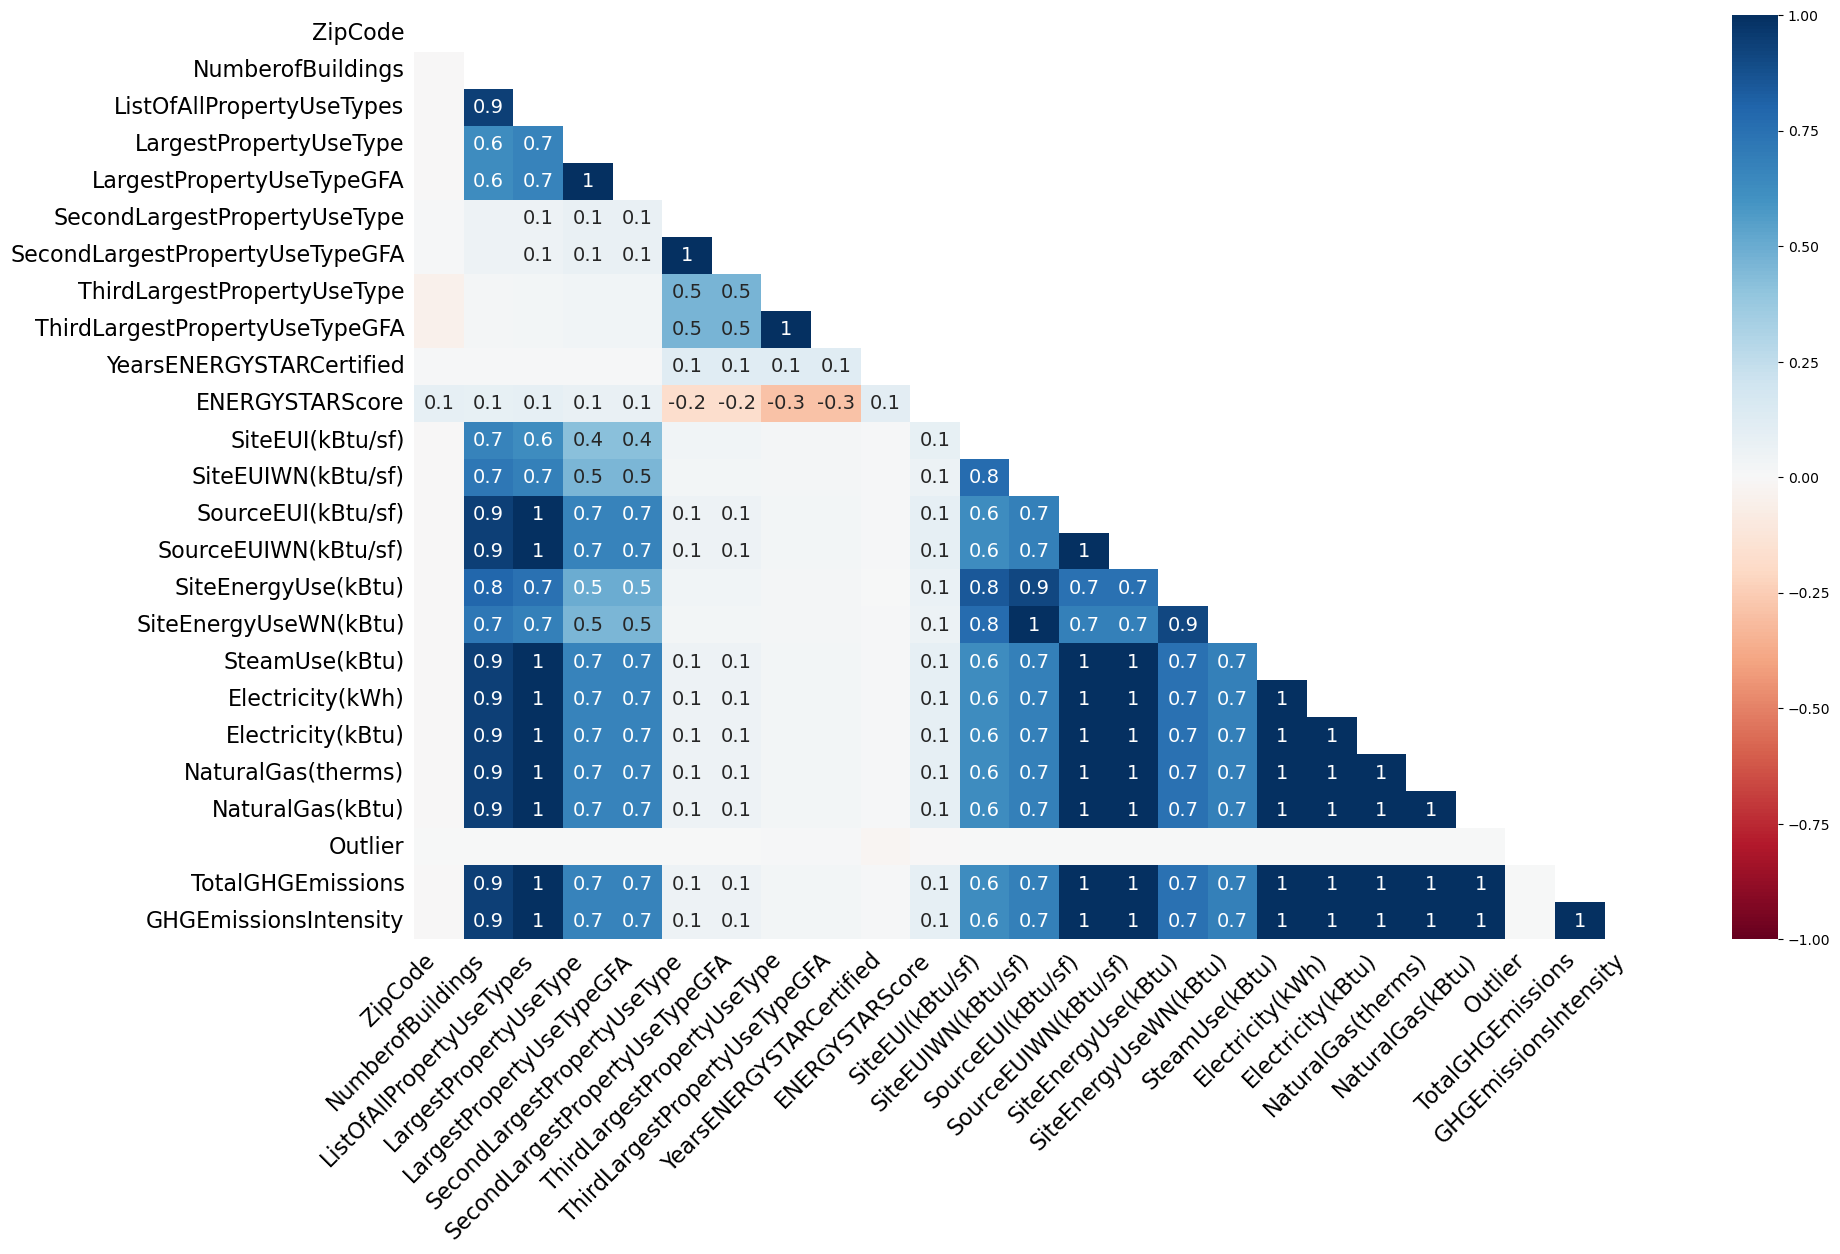

In [16]:
msno.heatmap(data)

## Définition et Compréhension des Variables

Après examen de la liste des variables et de leur définitions (https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy/about_data), nous avons établi la liste suivante :


| Name                          | Definition                                                                                     | Useful | Note |
|-------------------------------|------------------------------------------------------------------------------------------------|--------|------|
| OSEBuildingID                 | Identifiant unique attribué à chaque propriété couverte par l'ordonnance de référencement de Seattle. | Oui    | Essentiel pour suivre et identifier les propriétés |
| DataYear                      | Année civile représentée par chaque enregistrement de données.                                  | Non    |      |
| BuildingType                  | Classification du type de bâtiment de la ville de Seattle.                                     | Oui    | Utile pour des analyses par type de bâtiment |
| PrimaryPropertyType           | Utilisation principale d'une propriété (ex : bureau, magasin de détail).                        | Oui    | Utile pour des analyses par type d'utilisation |
| PropertyName                  | Nom officiel ou courant de la propriété.                                                        | Non    |      |
| Address                       | Adresse de la propriété.                                                                        | Oui    | Utile pour verifier les outliers |
| City                       | Ville de la propriété.                                                                        | Non    |      |
| State                       | Etat de la propriété.                                                                        | Non    |      |
| ZipCode                       | Code postal de la propriété.                                                                    | Oui    | Utile pour verifier les outliers |
| TaxParcelIdentificationNumber | Numéro d'identification de la parcelle fiscale de la propriété.                                 | Non    |      |
| CouncilDistrictCode           | Code du district du conseil de la ville de Seattle de la propriété.                             | Oui    | Utile pour des analyses géographiques |
| Neighborhood                  | Quartier de la propriété défini par le département des quartiers de la ville de Seattle.         | Oui    | Utile pour des analyses géographiques |
| Latitude                      | Latitude de la propriété.                                                                       | Oui    | Essentiel pour des analyses géospatiales |
| Longitude                     | Longitude de la propriété.                                                                      | Oui    | Essentiel pour des analyses géospatiales |
| YearBuilt                     | Année de construction de la propriété.                                                          | Oui    | Utile pour des analyses liées à l'âge du bâtiment |
| NumberofBuildings             | Nombre de bâtiments inclus dans le rapport de la propriété.                                     | Oui    | Utile pour des analyses de taille et de complexité |
| NumberofFloors                | Nombre d'étages signalés dans Portfolio Manager.                                                 | Oui    | Utile pour des analyses de taille et de complexité |
| PropertyGFATotal              | Surface brute totale du bâtiment et du parking.                                                 | Oui    | Utile pour des analyses de taille |
| PropertyGFAParking            | Espace total en pieds carrés de tous les types de stationnement.                                | Oui    | Utile pour des analyses de taille |
| PropertyGFABuilding(s)        | Surface brute totale en pieds carrés entre les surfaces extérieures des murs d'enceinte du bâtiment. | Oui    | Utile pour des analyses de taille |
| ListOfAllPropertyUseTypes     | Toutes les utilisations de la propriété signalées dans Portfolio Manager.                        | Non    |     |
| LargestPropertyUseType        | La plus grande utilisation de la propriété par la surface brute.                                | Oui    | Utile pour des analyses par type d'utilisation |
| LargestPropertyUseTypeGFA     | Surface brute de la plus grande utilisation de la propriété.                                    | Oui    | Utile pour des analyses par type d'utilisation |
| SecondLargestPropertyUseType  | La deuxième plus grande utilisation de la propriété par la surface brute.                        | Oui    | Utile pour des analyses par type d'utilisation |
| SecondLargestPropertyUseTypeGFA | Surface brute de la deuxième plus grande utilisation de la propriété.                          | Oui    | Utile pour des analyses par type d'utilisation |
| ThirdLargestPropertyUseType   | La troisième plus grande utilisation de la propriété par la surface brute.                       | Oui    | Utile pour des analyses par type d'utilisation |
| ThirdLargestPropertyUseTypeGFA| Surface brute de la troisième plus grande utilisation de la propriété.                          | Oui    | Utile pour des analyses par type d'utilisation |
| YearsENERGYSTARCertified      | Années où la propriété a reçu la certification ENERGY STAR.                                     | Non    |      |
| ENERGYSTARScore               | Score calculé pour évaluer la performance énergétique globale de la propriété.               | Oui    | Objectif |
| SiteEUI(kBtu/sf)              | Intensité d'utilisation de l'énergie sur site (EUI) de la propriété.                            | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEUIWN(kBtu/sf)            | EUI du site normalisée (WN) de la propriété.                                  | Oui    | Fuite des données mais utile pour des vérifications |
| SourceEUI(kBtu/sf)            | Intensité d'utilisation de l'énergie source (EUI) de la propriété.                              | Oui    | Fuite des données mais utile pour des vérifications |
| SourceEUIWN(kBtu/sf)          | EUI de l'énergie source normalisée (WN) de la propriété.                            | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEnergyUse(kBtu)           | Quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie. | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEnergyUseWN(kBtu)         | Quantité annuelle d'énergie consommée par la propriété, ajustée aux conditions météorologiques moyennes sur 30 ans. | Oui | Objectif |
| SteamUse(kBtu)                | Quantité annuelle de vapeur de district consommée par la propriété sur place.                    | Oui    | Fuite des données mais peut indiquer la nature de la source d'energie |
| Electricity(kWh)              | Quantité annuelle d'électricité consommée par la propriété sur place.                            | Oui    | Fuite des données mais utile pour des vérifications |
| Electricity(kBtu)             | Quantité annuelle d'électricité consommée par la propriété sur place, mesurée en milliers de BTU. | Oui    | Fuite des données mais peut indiquer la nature de la source d'energie |
| NaturalGas(therms)            | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété.     | Oui    | Fuite des données mais utile pour des vérifications |
| NaturalGas(kBtu)              | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en milliers de BTU. | Oui | Fuite des données mais peut indiquer la nature de la source d'energie |
| DefaultData                   | La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété.  | Non    |      |
| Comments                      | Commentaires d'un propriétaire ou d'un agent pour fournir un contexte à l'utilisation de l'énergie du bâtiment. | Non  |      |
| ComplianceStatus              | Si une propriété a respecté les exigences de référencement énergétique pour l'année de déclaration en cours. | Oui  |      |
| Outlier                       | Si une propriété est un cas extrême élevé ou faible (O/N).                                       | Oui    |      |
| TotalGHGEmissions             | Quantité totale d'émissions de gaz à effet de serre.                                             | Oui    | Objectif |
| GHGEmissionsIntensity         | Émissions totales de gaz à effet de serre divisées par la surface brute de la propriété.         | Oui    | Fuite des données mais utile pour des vérifications |

In [17]:
cols_to_drop = ['DataYear', 'City', 'State', 'PropertyName','TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes',
                'YearsENERGYSTARCertified', 'DefaultData','Comments']

# Liste de toutes les colonnes à conserver
cols_to_keep = data.columns.difference(cols_to_drop)

# Nettoyage des Données

## Format des données

In [18]:
data[cols_to_keep].dtypes

Address                             object
BuildingType                        object
ComplianceStatus                    object
CouncilDistrictCode                  int64
ENERGYSTARScore                    float64
Electricity(kBtu)                  float64
Electricity(kWh)                   float64
GHGEmissionsIntensity              float64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
Longitude                          float64
NaturalGas(kBtu)                   float64
NaturalGas(therms)                 float64
Neighborhood                        object
NumberofBuildings                  float64
NumberofFloors                       int64
OSEBuildingID                        int64
Outlier                             object
PrimaryPropertyType                 object
PropertyGFABuilding(s)               int64
PropertyGFAParking                   int64
PropertyGFATotal                     int64
SecondLarge

In [19]:
# Verification des années
print("Valeurs uniques pour YearBuilt dans data:", data['YearBuilt'].unique())

Valeurs uniques pour YearBuilt dans data: [1927 1996 1969 1926 1980 1999 1904 1910 1998 1928 1922 2004 1930 1983
 1907 1916 1985 1961 2001 1991 1955 1978 1949 1989 1906 1994 1992 1990
 1950 1900 1954 1911 1973 1920 1982 1908 1959 2000 1997 1962 1970 2008
 1948 1965 1929 2010 1938 1986 2002 1923 2003 1957 1964 1941 1963 2006
 1915 1958 2009 2011 1971 2007 1951 1953 1952 1960 1937 1966 1968 1925
 1924 2005 1909 1931 1972 1914 1913 1917 1995 1981 1976 1988 1979 1947
 1984 1956 1912 1977 1921 1945 1974 1975 1946 1967 1987 1940 1932 1993
 1918 1905 1902 1939 1944 1942 1903 2012 2013 2015 1901 1919 2014 1936
 1935]


Le format de l'année dans YearBuilt est en int mais ce n'est pas génant donc nous le laissons ainsi et remplaçons cette colonne par l'âge du batiment.

In [20]:
# Calculer l'âge des bâtiments et créer la colonne 'BuildingAge'
data['BuildingAge'] = 2016 - data['YearBuilt']

# Supprimer la colonne 'YearBuilt'
data.drop(columns=['YearBuilt'], inplace=True)

In [21]:
# Verification des BuildingType
print("Valeurs uniques pour BuildingType dans data:", data['BuildingType'].unique())

Valeurs uniques pour BuildingType dans data: ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [22]:
# Verification des ComplianceStatus
print("Valeurs uniques pour ComplianceStatus dans data:", data['ComplianceStatus'].unique())

Valeurs uniques pour ComplianceStatus dans data: ['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']


In [23]:
print(data['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: count, dtype: int64


In [24]:
print("Valeurs uniques pour Outlier dans data:", data['Outlier'].unique())

Valeurs uniques pour Outlier dans data: [nan 'High outlier' 'Low outlier']


In [25]:
# Verification des CouncilDistrictCode 
print("Valeurs uniques pour CouncilDistrictCode dans data:", data['CouncilDistrictCode'].unique())

Valeurs uniques pour CouncilDistrictCode dans data: [7 3 2 4 5 6 1]


In [26]:
# Verification des Neighborhood 
print("Valeurs uniques pour Neighborhood dans data:", data['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']


In [27]:
# Corrections
data['Neighborhood'] = data['Neighborhood'].str.upper()
data['Neighborhood'] = data['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print("Valeurs uniques pour Neighborhood dans data:", data['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'CENTRAL' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'SOUTHWEST' 'DELRIDGE']


In [28]:
# Vérification des ZipCode
print("Valeurs uniques pour ZipCode dans data:", data['ZipCode'].unique())

Valeurs uniques pour ZipCode dans data: [98101. 98121. 98104. 98154. 98118. 98105. 98112. 98125. 98109. 98070.
 98108. 98199. 98115. 98107. 98144. 98103. 98119. 98136. 98122. 98126.
 98133. 98146. 98033. 98106. 98111. 98134. 98117. 98116. 98191. 98164.
 98195. 98185. 98181. 98102. 98168. 98155. 98006. 98124. 98053. 98012.
 98013. 98028. 98178. 98114. 98127. 98165. 98011. 98198. 98113. 98040.
 98204. 98177. 98020. 98272. 98145.    nan]


In [29]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour LargestPropertyUseType dans data:", data['LargestPropertyUseType'].unique())

Valeurs uniques pour LargestPropertyUseType dans data: ['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Multifamily Housing' 'Library' 'Fitness Center/Health Club/Gym'
 'Social/Meeting Hall' 'Courthouse' 'Other' 'K-12 School'
 'College/University' 'Automobile Dealership' 'Office'
 'Self-Storage Facility' 'Non-Refrigerated Warehouse' 'Other - Mall'
 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital (General Medical & Surgical)' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory'
 'Other/Specialty Hospital' 'Financial Office' 'Distribution Center'
 'Parking' 'Worship Facility' 'Restaurant' 'Data Center' 'Laboratory'
 'Supermarket/Grocery Store' 'Convention Center'
 'Urgent Care/Clinic/Other Outpatient' nan 'Other - Services' 'Strip Mall'
 'Wholesale Club/Supercenter' 'Refrigerated Warehouse'
 'Manufacturing/Industrial Plant' 'Other - Recreation' 'Lifestyle Center'
 'Other - Public Servic

In [30]:
# Vérification des SecondLargestPropertyUseType
print("Valeurs uniques pour SecondLargestPropertyUseType dans data:", data['SecondLargestPropertyUseType'].unique())

Valeurs uniques pour SecondLargestPropertyUseType dans data: [nan 'Parking' 'Office' 'Restaurant' 'K-12 School' 'Laboratory'
 'Refrigerated Warehouse' 'Non-Refrigerated Warehouse' 'Other - Education'
 'Vocational School' 'Retail Store'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Other - Entertainment/Public Assembly' 'Data Center' 'Swimming Pool'
 'Other' 'Courthouse' 'Residence Hall/Dormitory' 'Distribution Center'
 'Self-Storage Facility' 'Other - Services' 'Movie Theater'
 'Supermarket/Grocery Store' 'Medical Office' 'Other - Recreation'
 'Convenience Store without Gas Station' 'Performing Arts'
 'College/University' 'Other - Restaurant/Bar' 'Adult Education'
 'Enclosed Mall' 'Multifamily Housing' 'Bar/Nightclub' 'Financial Office'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Manufacturing/Industrial Plant' 'Other - Lodging/Residential'
 'Bank Branch' 'Food Service' 'Worship Facility' 'Senior Care Community'
 'Fitness Center/Health Club/Gym' 'Hotel' 'Food Sales

In [31]:
# Vérification des ThirdLargestPropertyUseType
print("Valeurs uniques pour ThirdLargestPropertyUseType dans data:", data['ThirdLargestPropertyUseType'].unique())

Valeurs uniques pour ThirdLargestPropertyUseType dans data: [nan 'Restaurant' 'Swimming Pool' 'Data Center' 'Office' 'Retail Store'
 'Other - Entertainment/Public Assembly' 'Non-Refrigerated Warehouse'
 'Other' 'Distribution Center' 'Food Service' 'Other - Services'
 'Medical Office' 'Parking' 'Other - Utility'
 'Other - Lodging/Residential' 'K-12 School'
 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Pre-school/Daycare' 'Convenience Store without Gas Station'
 'Financial Office' 'Other - Restaurant/Bar' 'Other - Education'
 'Multifamily Housing' 'Laboratory' 'Bank Branch' 'Hotel'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Other - Recreation' 'Self-Storage Facility' 'Other - Technology/Science'
 'Refrigerated Warehouse' 'Fast Food Restaurant' 'Bar/Nightclub'
 'Manufacturing/Industrial Plant' 'Food Sales' 'Supermarket/Grocery Store'
 'Other/Specialty Hospital' 'Worship Facility' 'Strip Mall'
 'Residence Hall/Dormitory' 'Vocational School' 'College/University'
 

In [32]:
# Vérification des PrimaryPropertyType
print("Valeurs uniques pour PrimaryPropertyType dans data:", data['PrimaryPropertyType'].unique())

Valeurs uniques pour PrimaryPropertyType dans data: ['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'University' 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Warehouse' 'Large Office' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital' 'Residence Hall' 'Distribution Center'
 'Worship Facility' 'Low-Rise Multifamily' 'Supermarket / Grocery Store'
 'Laboratory' 'Refrigerated Warehouse' 'Restaurant'
 'High-Rise Multifamily' 'Office']


Pas de problèmes sur le format des données des 'use Type'

## Sélection des données

Suppression des variables que nous n'avons pas trouvé pertinantes pour l'étude.

In [33]:
df_filtered = data.drop(columns=cols_to_drop).copy()

Notre étude porte uniquement sur les bâtiments non résidentiel, donc nous supprimons les bâtiments non concernés.

In [34]:
# Selection des batiments résidentiels
df_filtered = df_filtered[~df_filtered['BuildingType'].str.contains("Multifamily", na=False)].copy()
df_filtered = df_filtered[~df_filtered['PrimaryPropertyType'].str.contains("Multifamily", na=False)].copy()
df_filtered = df_filtered[~df_filtered['PrimaryPropertyType'].str.contains("Residence Hall", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Residence Hall/Dormitory", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Lodging", na=False)].copy()

In [35]:
df_filtered.shape

(1638, 37)

## Recherche des doublons

In [36]:
nb_doublons_code = df_filtered.duplicated(subset=["OSEBuildingID"]).sum()
print('Nombre de doublons sur le OSEBuildingID :', nb_doublons_code)

Nombre de doublons sur le OSEBuildingID : 0


In [37]:
nb_doublons_add = df_filtered.duplicated(subset=['Address','PropertyGFATotal']).sum()
print('Nombre de doublons sur l\'adresse :', nb_doublons_add)

Nombre de doublons sur l'adresse : 1


In [38]:
print(data[data.duplicated(['Address','PropertyGFATotal'], keep=False)].sort_values('Address'))

     OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
348            490      2016  NonResidential  Small- and Mid-Sized Office   
349            491      2016  NonResidential  Small- and Mid-Sized Office   

    PropertyName            Address     City State  ZipCode  \
348  North Tower  100 West Harrison  Seattle    WA  98119.0   
349  South Tower  100 West Harrison  Seattle    WA  98119.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
348                    1989200720                    7  MAGNOLIA / QUEEN ANNE   
349                    1989200740                    7  MAGNOLIA / QUEEN ANNE   

     Latitude  Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
348  47.62224  -122.3585                1.0               5             87178   
349  47.62224  -122.3585                1.0               5             87178   

     PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
348          

Ce sont bien deux bâtiments différents (Tour nord et tour sud) donc  il n'y a pas de doublons.

## Gestion des valeurs aberrantes

In [39]:
df_filtered.dtypes.value_counts()

float64    21
object      9
int64       7
Name: count, dtype: int64

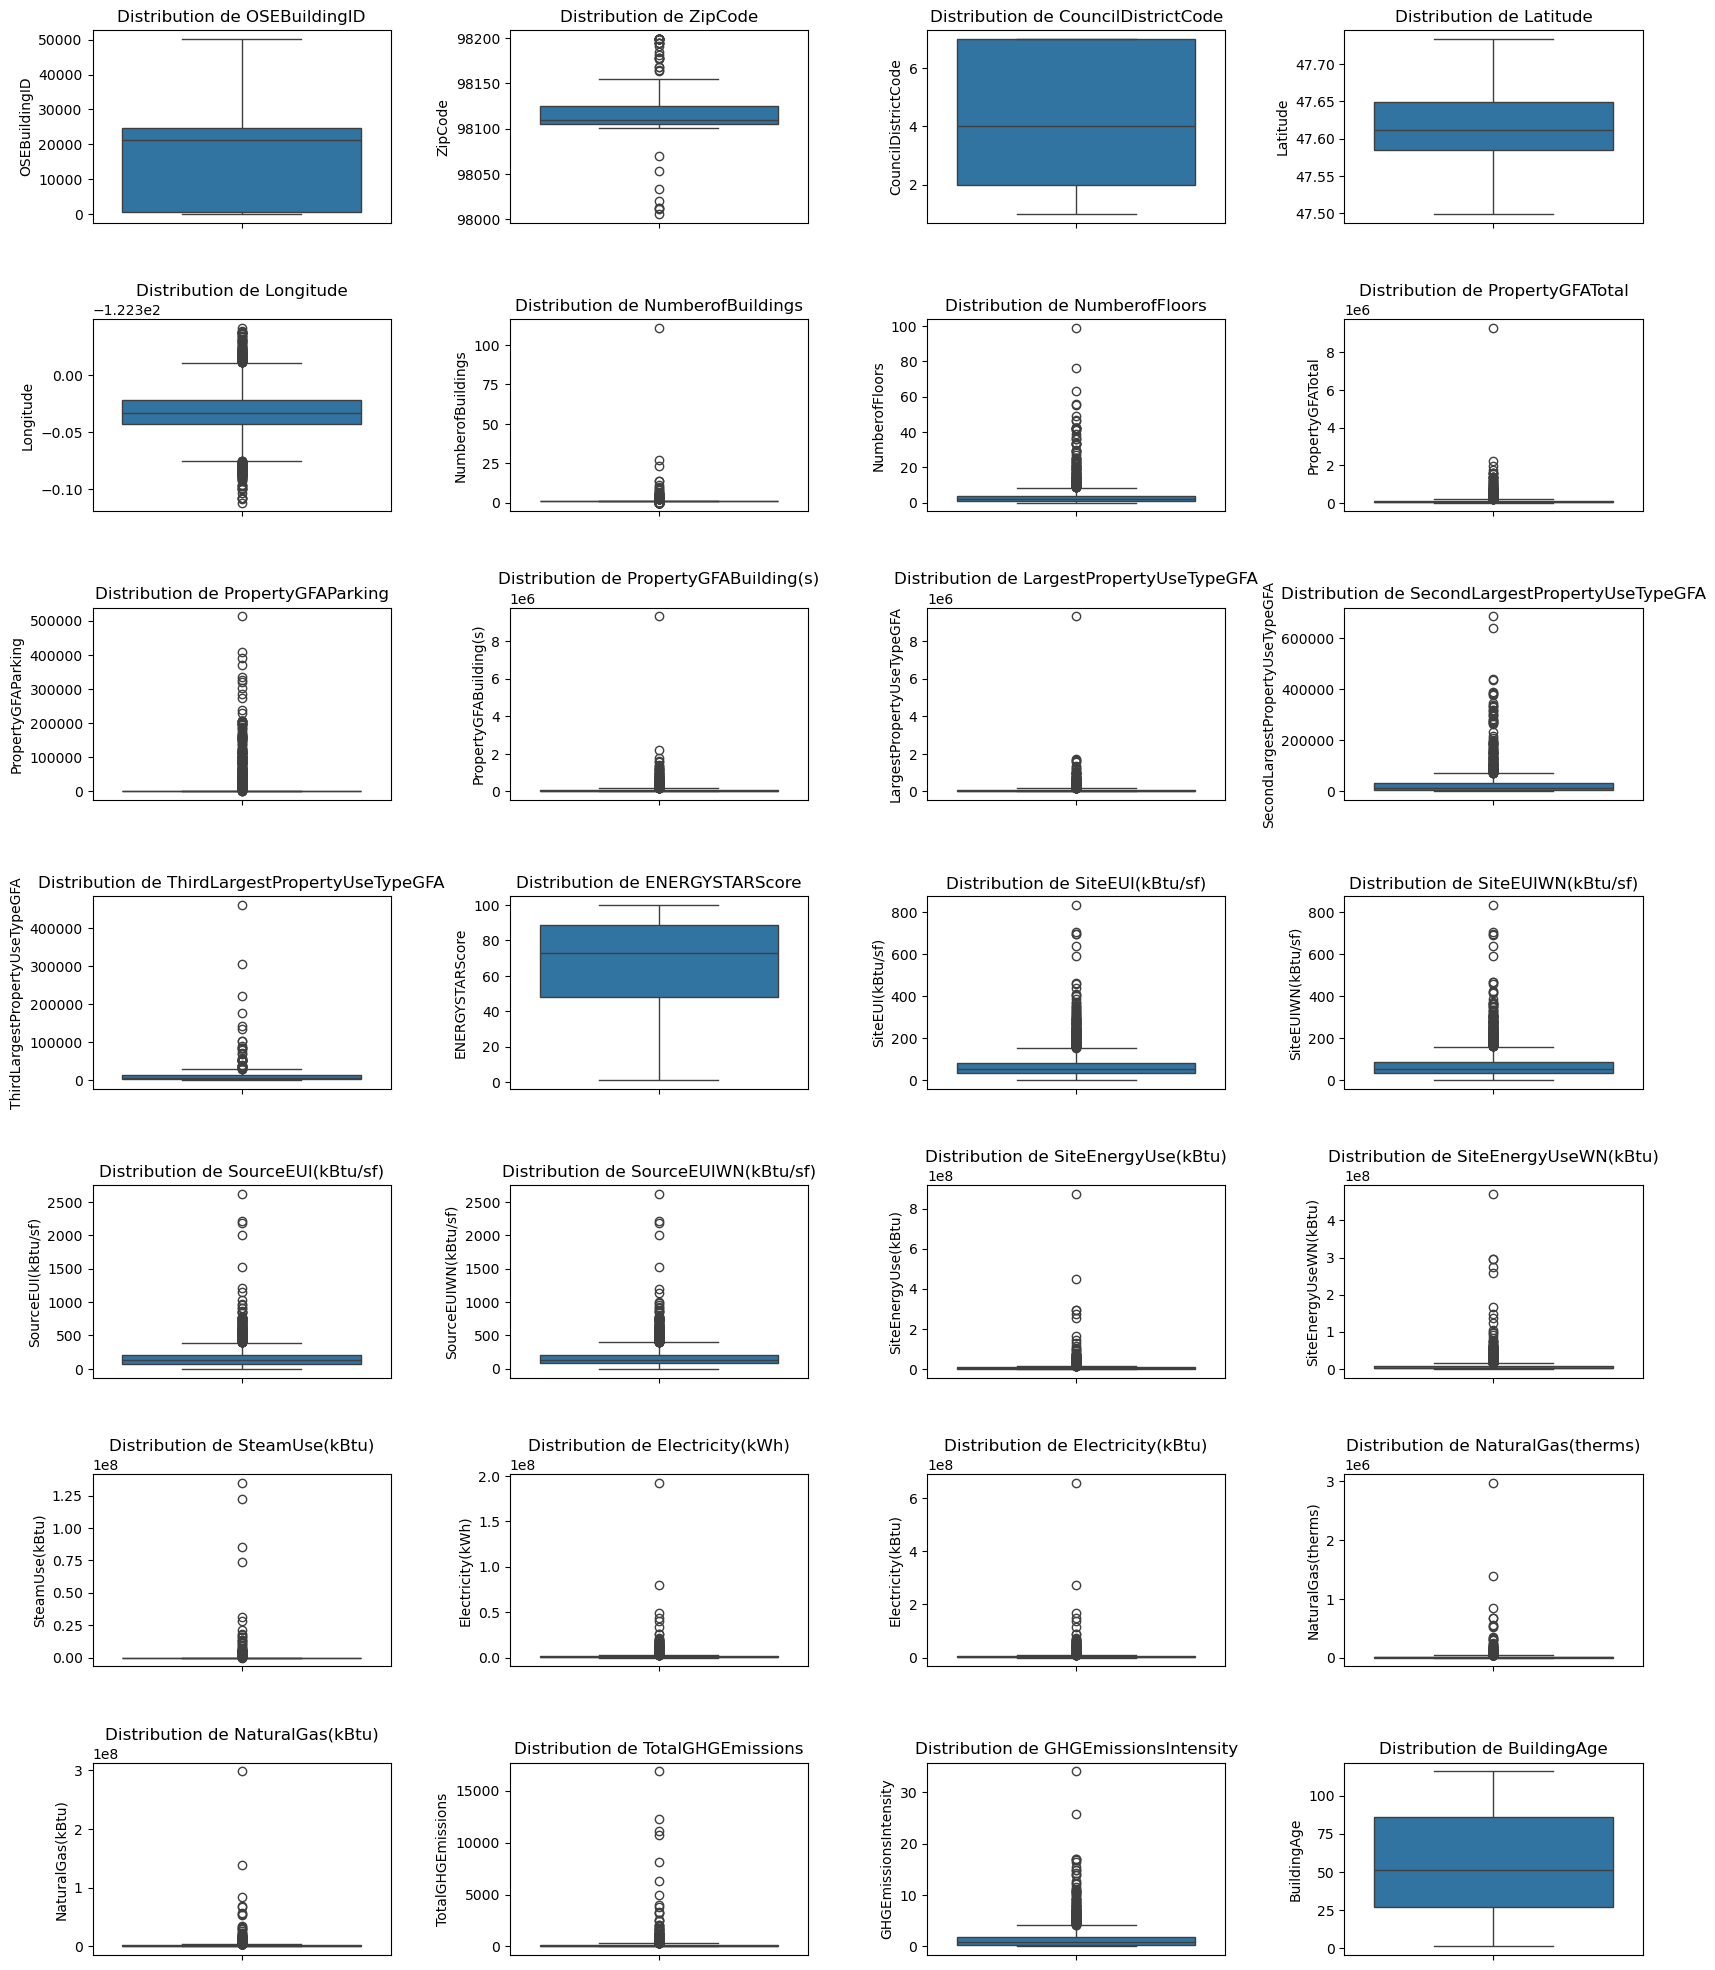

In [40]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df_filtered.select_dtypes(include=['number']).columns
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20,25))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df_filtered[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 28):
    fig.delaxes(axes.flatten()[j])

plt.show()

### Vérification des ZipCode

In [41]:
# Vérification des ZipCode
print("Valeurs uniques pour ZipCode dans data:", data['ZipCode'].unique())

Valeurs uniques pour ZipCode dans data: [98101. 98121. 98104. 98154. 98118. 98105. 98112. 98125. 98109. 98070.
 98108. 98199. 98115. 98107. 98144. 98103. 98119. 98136. 98122. 98126.
 98133. 98146. 98033. 98106. 98111. 98134. 98117. 98116. 98191. 98164.
 98195. 98185. 98181. 98102. 98168. 98155. 98006. 98124. 98053. 98012.
 98013. 98028. 98178. 98114. 98127. 98165. 98011. 98198. 98113. 98040.
 98204. 98177. 98020. 98272. 98145.    nan]


In [42]:
# Colonnes à afficher
cols_to_display = ['Address', 'ZipCode', 'Neighborhood', 'Latitude', 'Longitude']

# Filtrer les lignes où ZipCode est égal à 98145 puis afficher les colonnes spécifiées
filtered_df = df_filtered.loc[df_filtered['ZipCode'].isin([98145]), cols_to_display]

print(filtered_df)


               Address  ZipCode Neighborhood  Latitude  Longitude
3187  4500 40th Ave NE  98145.0    NORTHEAST  47.66201 -122.28386


D'après GoogleMaps, les coordonnées  47.66201, -122.28386 correspondent à cette adresse : 4800 40th Ave NE, Seattle, WA 98105, États-Unis => ZipCode à corriger

In [43]:
df_filtered.loc[df_filtered['Address'] == '4500 40th Ave NE', 'ZipCode'] = 98105

Les autres ZipCode correspondent bien à la métropole de Seattle.

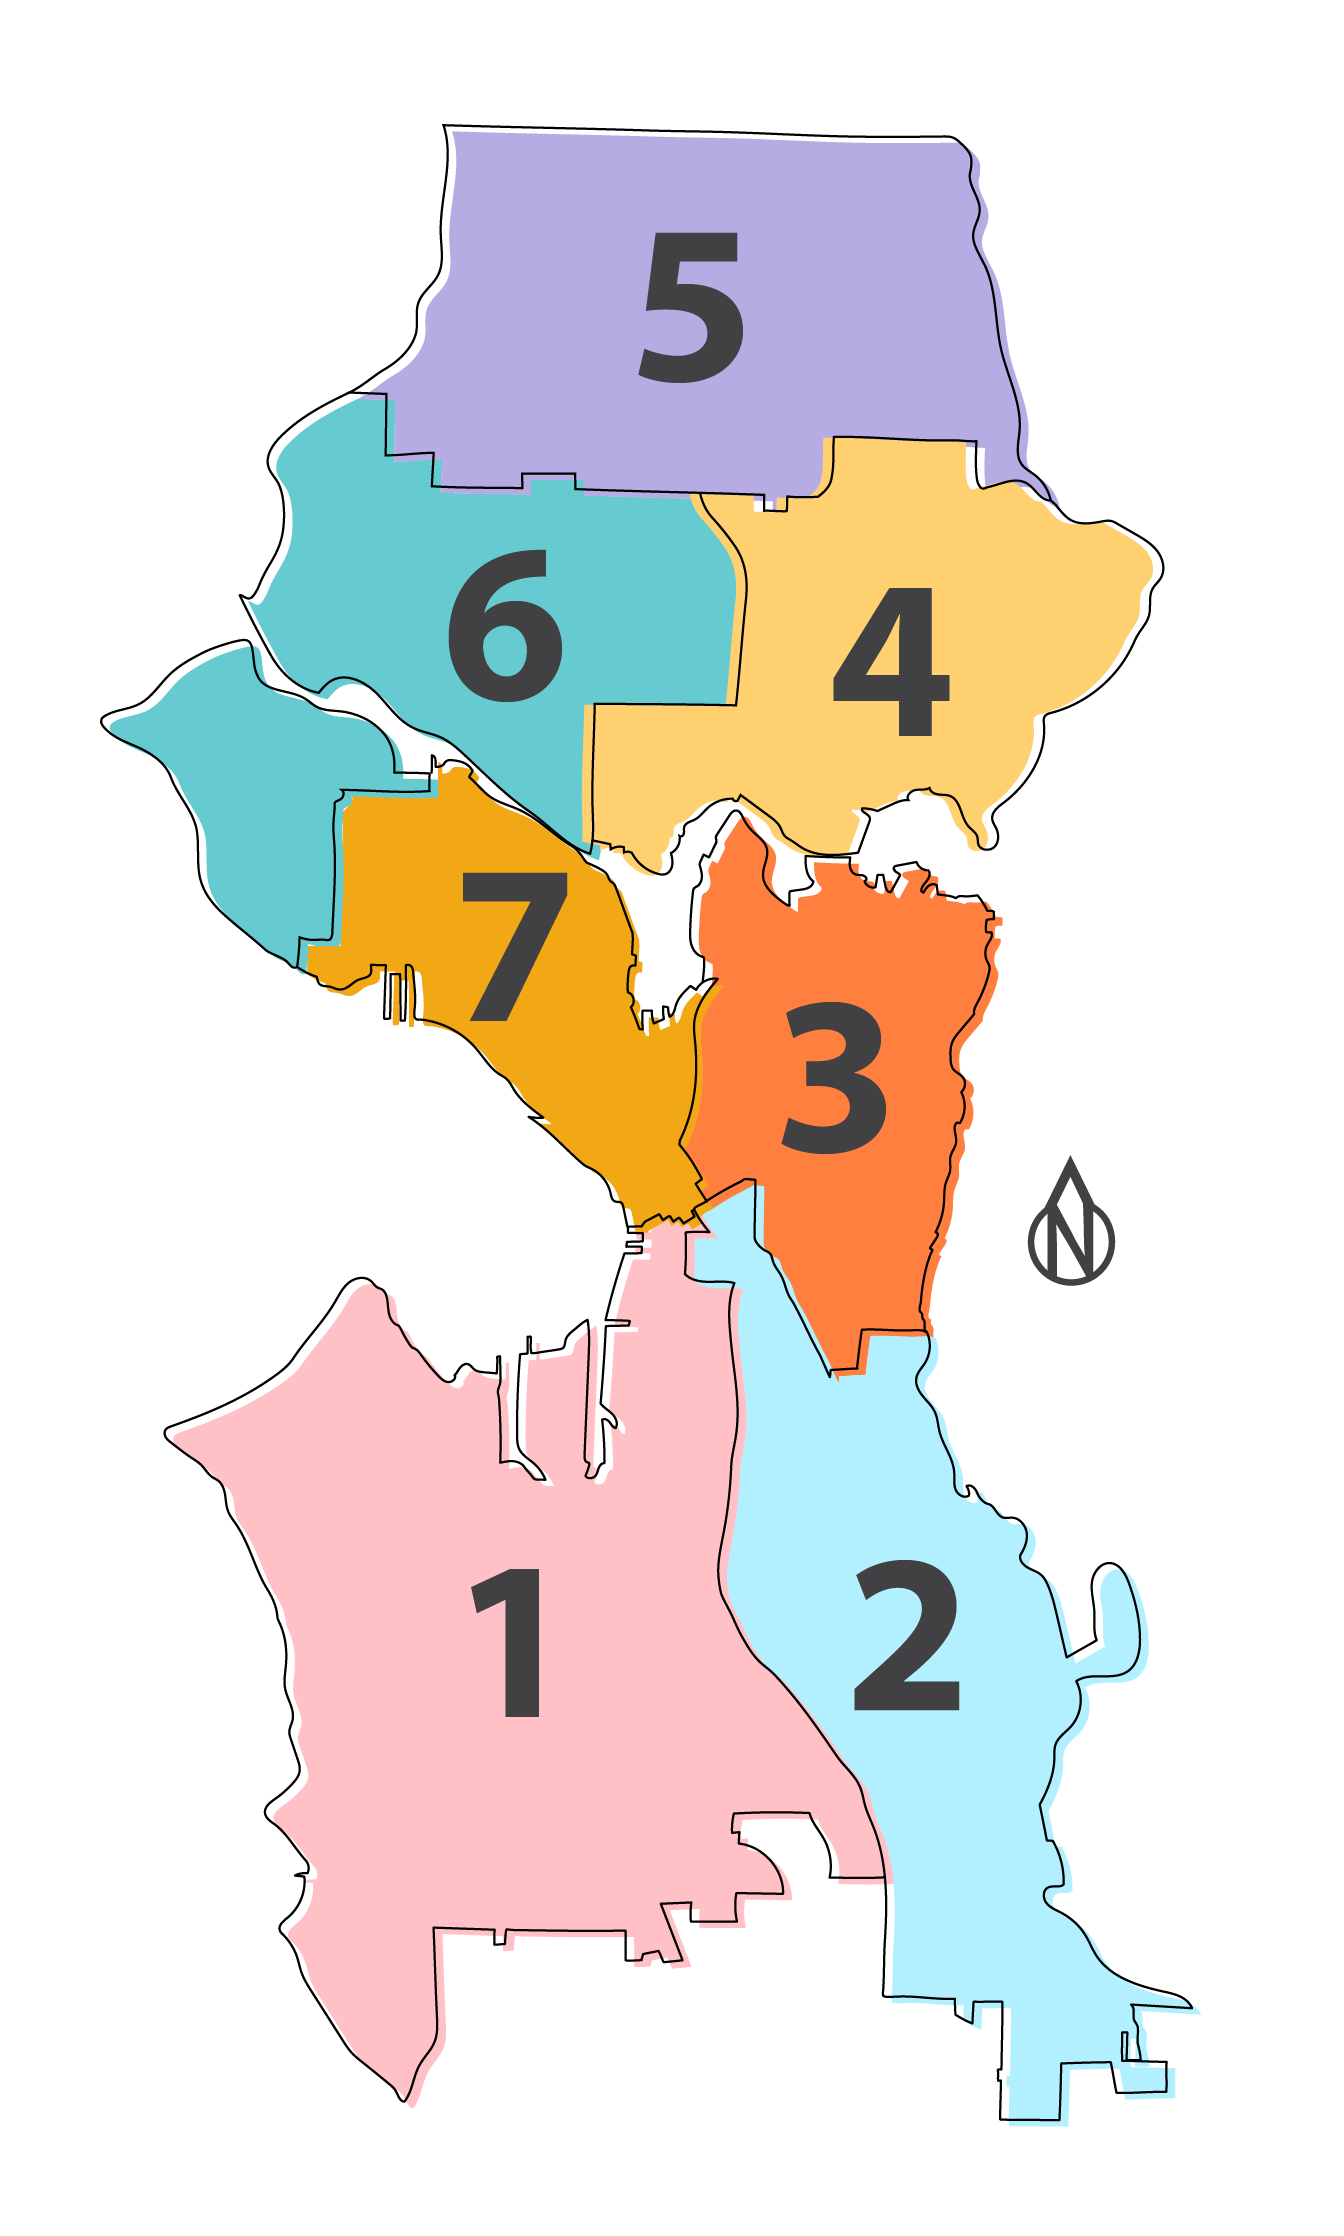

In [44]:
# Afficher les district de Seattle
Image(filename="Council District Map - 2024 - FULL.png", width=300, height=100)

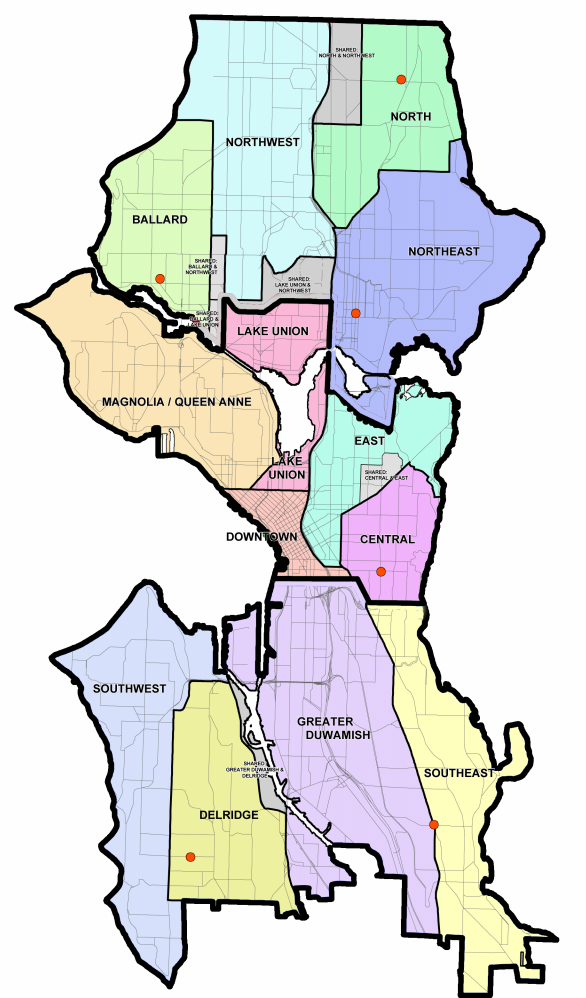

In [45]:
# Afficher les quartiers de Seattle
Image(filename="Map_of_Seattle,_divided_by_districts.png", width=400, height=150)

In [46]:
def find_outliers_by_group(df, groupby_var, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df.groupby(groupby_var)[outlier_var].quantile(0.25)
    q3 = df.groupby(groupby_var)[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Initialiser une liste pour stocker les DataFrame des outliers
    outliers_list = []

    # Identifier les outliers pour chaque groupe
    for group in df[groupby_var].dropna().unique():
        lower_bound_group = lower_bound.get(group, np.nan)
        upper_bound_group = upper_bound.get(group, np.nan)
        # Utiliser les valeurs obtenues pour filtrer les outliers, en vérifiant aussi que les bornes ne sont pas NaN
        if not np.isnan(lower_bound_group) and not np.isnan(upper_bound_group):
            outliers_group = df[(df[groupby_var] == group) & 
                                ((df[outlier_var] < lower_bound_group) | 
                                 (df[outlier_var] > upper_bound_group))]
            if not outliers_group.empty:
                outliers_list.append(outliers_group)

    # Concaténer les DataFrame des outliers, en vérifiant d'abord si la liste n'est pas vide
    if outliers_list:
        outliers = pd.concat(outliers_list, ignore_index=True)
        return outliers
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide si aucun outlier n'est trouvé



### Vérification de la longitude

Seattle :

    Longitude minimale : aux alentours de -122.436 (ouest)
    Longitude maximale : aux alentours de -122.255 (est)

In [47]:
# Définir les limites de longitude pour Seattle
longitude_min = -122.436
longitude_max = -122.255

# Sélectionner les lignes en dehors de cette fourchette de longitude
outliers_longitude = df_filtered[(df_filtered['Longitude'] < longitude_min) | (df_filtered['Longitude'] > longitude_max)]

# Afficher les valeurs aberrantes
outliers_longitude[['Address', 'ZipCode', 'Neighborhood', 'Latitude', 'Longitude', 'CouncilDistrictCode']]

Empty DataFrame
Columns: [Address, ZipCode, Neighborhood, Latitude, Longitude, CouncilDistrictCode]
Index: []

Les valeurs sont donc atypiques mais pas abérrantes géographiquement parlant.

### Vérification des NumberofBuildings

In [48]:
# Compter et trier le nombre de valeurs
NumberofBuildings_counts = df_filtered['NumberofBuildings'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofBuildings': NumberofBuildings_counts})

NumberofBuildings
NumberofBuildings                   
111.0                              1
27.0                               1
23.0                               1
14.0                               2
11.0                               1
10.0                               1
9.0                                1
8.0                                2
7.0                                1
6.0                                4
5.0                                8
4.0                                4
3.0                               12
2.0                               14
1.0                             1533
0.0                               50

Il y a forcément au moins 1 bâtiment par adresse, la valeur la plus fréquente étant 1 on remplace les 0 par 1

In [49]:
df_filtered.loc[df_filtered['NumberofBuildings'] == 0.] = 1.

Les adresses avec plus de 7 bâtiments sont à vérifier.

In [50]:
# Sélectionner les lignes où le nombre de bâtiments est supérieur à 10
buildings_over_10 = df_filtered[df_filtered['NumberofBuildings'] > 10]
buildings_over_10[['Address', 'ZipCode', 'NumberofBuildings', 'PrimaryPropertyType']]

Address  ZipCode  NumberofBuildings  \
105             6000 16th Ave SW  98106.0               27.0   
128           9600 COLLEGE WAY N  98103.0               11.0   
162               1420 S Trenton  98108.0               14.0   
1862  1900 West Nickerson Street  98119.0               23.0   
2325             3307 3rd Ave. W  98119.0               14.0   
3274   NE 45th St & Brooklyn Ave  98105.0              111.0   

     PrimaryPropertyType  
105           University  
128           University  
162         Large Office  
1862               Other  
2325          University  
3274          University

Nombre de batiments pas abérrants sauf pour l'université avec 111 bâtiments. Il n'y a pas d'université à l'adresse indiqué et quant bien même cette valeur serait trop atypique et poserait problème pour nos modèles.

In [51]:
df_filtered = df_filtered.loc[df_filtered['NumberofBuildings'] != 111.]

### Vérification des NumberofFloors

In [52]:
# Compter et trier le nombre de valeurs
NumberofFloors_counts = df_filtered['NumberofFloors'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofFloors': NumberofFloors_counts})

NumberofFloors
NumberofFloors                
99                           1
76                           1
63                           1
56                           1
55                           1
49                           1
47                           1
46                           1
42                           5
41                           2
39                           1
37                           1
36                           2
34                           2
33                           3
30                           1
29                           3
28                           1
27                           1
25                           3
24                           2
23                           3
22                           3
21                           3
20                           3
19                           4
18                           3
17                           4
16                           3
15                           5
14                           9
13                           7
12                           9
11                          18
10                          16
9                            7
8                           21
7                           33
6                           82
5                           97
4                          137
3                          244
2                          378
1                          503
0                           10

In [53]:
# Colonnes à afficher
cols_to_display = ['Address', 'ZipCode','NumberofFloors', 'PrimaryPropertyType']
print(df_filtered[cols_to_display].loc[df_filtered['NumberofFloors'] >60])

                       Address  ZipCode  NumberofFloors PrimaryPropertyType
233           700 Fifth Avenue  98104.0              63        Large Office
559             701 5th Avenue  98104.0              76        Large Office
1359  5801 Beacon Avenue South  98108.0              99    Worship Facility


A corriger :

    5801 Beacon Avenue South correspond à une église => remplacer par 1

In [54]:
df_filtered.loc[df_filtered['Address'] == '5801 Beacon Avenue South', 'NumberofFloors'] = 1

In [55]:
outliers = find_outliers_by_group(df_filtered, 'PrimaryPropertyType', 'NumberofFloors', 3)
if not outliers.empty:
    display(outliers[['Address', 'ZipCode', 'NumberofFloors', 'PrimaryPropertyType']])
else:
    print("Aucun outlier trouvé.")

Address  ZipCode  NumberofFloors  \
0                     1900 5th Avenue  98101.0              41   
1                        1113 6th Ave  98101.0              33   
2                     1400 6th Avenue  98101.0              34   
3                  1000 Fourth Avenue  98154.0              11   
4                         516 3RD AVE  98104.0              10   
5                         500 5TH AVE  98104.0              19   
6                       1900 9th Ave.  98101.0              11   
7                        1122 3rd Ave  98101.0              15   
8                          120 Lenora  98121.0              12   
9                        2001 6th Ave  98121.0              33   
10                     1220 HOWELL ST  98101.0              11   
11             1200 12th Avenue South  98144.0              14   
12                 1500-1506 4th Ave.  98011.0              11   
13                      737 Olive Way  98101.0              39   
14  2201 9th Ave. / 820 Blanchard St.  98121.0              19   
15                    1000 Lenora St.  98121.0               7   
16                     625 5th Ave. S  98104.0              11   
17                   2203 1st Ave. S.  98134.0               7   
18                   700 Fifth Avenue  98104.0              63   
19                       1201 3rd ave  98101.0              55   
20                      601 Union St.  98101.0              56   
21                     701 5th Avenue  98104.0              76   
22                    500 Pine Street  98101.0              10   
23                    300 PINE STREET  98181.0               8   
24                 619 Western Avenue  98104.0               6   
25                     3613 4th Ave S  98134.0               2   
26            7272 W. Marginal Way S.  98108.0               2   
27                   270 S HANFORD ST  98134.0               2   
28                     1000 1st Ave S  98134.0               6   
29                     1014 1st Ave S  98134.0               4   
30                     2700 4th Ave S  98134.0               2   
31             5615 W Marginal Way SW  98106.0               2   
32       1200-1210 West Nickerson st.  98119.0               2   
33                  1529 Fourth Ave W  98119.0               3   
34                   901 Boren Avenue  98104.0              19   
35                      509 Olive Way  98101.0              18   
36             13000 Lake City Way NE  98125.0               2   
37               1401 Broadway Avenue  98122.0               3   
38             4545 Fauntleroy Way SW  98126.0               2   
39                  509-23 BROADWAY E  98122.0               2   
40                  500 Mercer Street  98109.0               4   
41                      516 1st Ave W  98119.0               4   
42                   5700 24th Ave NW  98107.0               8   
43                     4715 6th Ave S  98108.0               2   
44              2250 occidental ave s  98134.0               2   
45                    1411 1st Avenue  98101.0              13   

            PrimaryPropertyType  
0                         Hotel  
1                         Hotel  
2                         Hotel  
3                         Other  
4                         Other  
5                         Other  
6                         Other  
7                         Other  
8                         Other  
9                         Other  
10           Mixed Use Property  
11           Mixed Use Property  
12           Mixed Use Property  
13           Mixed Use Property  
14           Mixed Use Property  
15                   University  
16  Small- and Mid-Sized Office  
17                    Warehouse  
18                 Large Office  
19                 Large Office  
20                 Large Office  
21                 Large Office  
22                 Retail Store  
23                 Retail Store  
24                 Retail Store  
25          Distribution Center  
26       

Un restaurant avec 13 étage et après vérification sur la carte, cela semble être une erreur de saisie.
Mise à 0 temporaire pour lui appliquer la moyenne.<br>
Après vérification, les autres bâtiments ne sont pas des outliers.

In [56]:
df_filtered.loc[df_filtered['Address'] == '1411 1st Avenue', 'NumberofFloors'] = 0

Aux USA on compte le rez de chaussée comme un étage. Il y a donc necessairement au moins 1 étage par batiment.
Nous allons donc remplacer les valeurs à 0 par la moyenne en fonction de leur PrimaryPropertyType.

In [57]:
# Calculer la médiane du nombre d'étages pour chaque type de propriété et convertir en entiers
mean_floors_by_type = df_filtered[df_filtered['NumberofFloors'] > 0].groupby('PrimaryPropertyType')['NumberofFloors'].median().astype(int)


# Fonction pour remplacer les zéros par la moyenne correspondante
def replace_zero_with_mean(row):
    if row['NumberofFloors'] == 0:
        return mean_floors_by_type.get(row['PrimaryPropertyType'], 0)
    else:
        return row['NumberofFloors']


In [58]:
# Appliquer la fonction à la colonne 'NumberofFloors'
df_filtered['NumberofFloors'] = df_filtered.apply(replace_zero_with_mean, axis=1)

### Vérification des PropertyGFA

Le PropertyGFATotal ne peut pas par définition être plus petit que la somme des GFA des 3 principales utilisations. Ce sont donc des erreurs qu'il faut supprimer.

In [59]:
def check_total_vs_sum(row):
    # Vérifier si PropertyGFATotal est NaN et exclure de la vérification
    if pd.isna(row['PropertyGFATotal']):
        return False

    # Remplacer les NaN par 0 pour ce calcul uniquement
    largest_gfa = row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0
    second_largest_gfa = row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0
    third_largest_gfa = row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0

    # Calculer la somme des trois plus grandes utilisations de la propriété
    total_gfa = largest_gfa + second_largest_gfa + third_largest_gfa

    # Vérifier si PropertyGFATotal est inférieur ou égale à cette somme (marge de 15%)'
    return row['PropertyGFATotal'] < (total_gfa * 0.85)

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_total_vs_sum, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)



Nombre de lignes considérées comme outliers : 178


In [60]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal          PrimaryPropertyType  \
2524            153312        Senior Care Community   
2782                 1                          1.0   
2382                 1                          1.0   
361              66462                        Other   
2699             46485             Worship Facility   
16              103911                        Other   
1347             34005                  K-12 School   
2798             21036           Mixed Use Property   
3232                 1                          1.0   
1668             30659  Small- and Mid-Sized Office   

      LargestPropertyUseTypeGFA    SecondLargestPropertyUseType  \
2524                   148590.0                         Parking   
2782                        1.0                             1.0   
2382                        1.0                             1.0   
361                     72000.0                         Parking   
2699                    63922.0                             NaN   
16                      90000.0                          Office   
1347                    50337.0                             NaN   
2798                    11021.0  Fitness Center/Health Club/Gym   
3232                        1.0                             1.0   
1668                    27262.0      Non-Refrigerated Warehouse   

      SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  
2524                          72317.0                          4722.0  
2782                              1.0                             1.0  
2382                              1.0                             1.0  
361                           15000.0                             NaN  
2699                              NaN                             NaN  
16                            40000.0                             0.0  
1347                              NaN                             NaN  
2798                           8164.0                          7280.0  
3232                              1.0                             1.0  
1668                           8653.0                           285.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [61]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

In [62]:
df_filtered.shape

(1459, 37)

GFABuilding + GFAPArking est sensé être égale à GFATotal

In [63]:
def check_GFATotal_vs_GFABuilding_and_Parking(row):
    # Vérifier si PropertyGFATotal, PropertyGFABuilding(s) ou PropertyGFAParking est NaN et exclure de la vérification
    if pd.isna(row['PropertyGFATotal']) or pd.isna(row['PropertyGFABuilding(s)']) or pd.isna(row['PropertyGFAParking']):
        return False

    # Calculer la somme de PropertyGFABuilding(s) et PropertyGFAParking
    total_gfa_calculated = row['PropertyGFABuilding(s)'] + row['PropertyGFAParking']

    # Calculer les marges de 20% pour plus ou moins
    lower_bound = total_gfa_calculated * 0.80
    upper_bound = total_gfa_calculated * 1.20

    # Vérifier si PropertyGFATotal est dans la marge de tolérance
    return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_GFATotal_vs_GFABuilding_and_Parking, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 0


Cas des Parking, certains useType sont appelés Parking et peuvent donc fausser les résulats.<br>
Mais commencons par renommer les "other" qui correspondent à des Parking.

In [64]:
# Calculer la plage de tolérance de 10% pour PropertyGFAParking
tolerance = df_filtered['PropertyGFAParking'] * 0.10

# Mettre à jour PrimaryPropertyType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['PrimaryPropertyType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'PrimaryPropertyType'] = "Parking"

# Mettre à jour SecondLargestPropertyUseType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['SecondLargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'SecondLargestPropertyUseType'] = "Parking"

# Mettre à jour ThirdLargestPropertyUseType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['ThirdLargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'ThirdLargestPropertyUseType'] = "Parking"


On vérifie que PropertyGFAParking = PropertyUseTypeGFA si PropertyUseType = Parking (5% de marge)

In [65]:
def check_parking_gfa_compliance(row):
    # Vérifier si PropertyGFATotal est NaN et exclure de la vérification
    if (row['PropertyGFAParking'] == 0):
        return False
    
    parking_gfa = row['PropertyGFAParking']
    is_inconsistent = False  # Initialiser un drapeau pour indiquer l'incohérence

    # Calculer les marges pour chaque type de propriété et vérifier les conditions avec la marge de 5%
    for property_type in ['Largest', 'SecondLargest', 'ThirdLargest']:
        property_use_type = row.get(f'{property_type}PropertyUseType', None)
        property_type_gfa = row.get(f'{property_type}PropertyUseTypeGFA', 0)
        
        if property_use_type == "Parking":
            # Calculer la différence en valeur absolue et la marge de 5%
            diff = abs(parking_gfa - property_type_gfa)
            margin = 0.05 * property_type_gfa
            
            # Vérifier si la différence dépasse la marge de 5%
            if diff > margin:
                is_inconsistent = True  # Marquer comme incohérent si la condition est remplie

    return is_inconsistent

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_parking_gfa_compliance, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 128


In [66]:
#### Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal  PropertyGFAParking     LargestPropertyUseType  \
315             158600               38400                     Office   
3324            483397              166208                     Office   
511             158931               28381                     Office   
1806             57110               15812                     Office   
526             108245               14690                     Office   
1109             34636               31000      Senior Care Community   
401              58184                7450  Supermarket/Grocery Store   
380             130293               23400      Self-Storage Facility   
1283             41466                6062                     Office   
395              75844               19928                      Other   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
315                    125779.0                      Parking   
3324                   342173.0                      Parking   
511                     80157.0          Multifamily Housing   
1806                    36867.0                      Parking   
526                     64055.0              Adult Education   
1109                    36000.0                      Parking   
401                     51722.0                      Parking   
380                    130293.0                      Parking   
1283                    35404.0                   Laboratory   
395                     28442.0                       Office   

      SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  
315                           32821.0                         20000.0  
3324                         147597.0                             NaN  
511                           34302.0                         26937.0  
1806                          28390.0                             NaN  
526                           14621.0                         12359.0  
1109                              0.0                             NaN  
401                               0.0                             NaN  
380                            8800.0                             NaN  
1283                           5000.0                          1250.0  
395                           28441.0                         18961.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [67]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

On vérifie si PropertyGFATotal est bien égale à la somme de tous les GFA parking compris avec une marge de 20%.

In [68]:
def check_property_gfa(row):
    # Pas d'évaluation si PropertyGFATotal est nan
    if pd.isna(row['PropertyGFATotal']):
        return False
    
    # Initialiser total_gfa_sum avec PropertyGFAParking si ce n'est pas nan
    total_gfa_sum = row['PropertyGFAParking'] if pd.notna(row['PropertyGFAParking']) else 0
    
    # Ajouter LargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if row['PrimaryPropertyType'] != "Parking" and pd.notna(row['LargestPropertyUseTypeGFA']):
        total_gfa_sum += row['LargestPropertyUseTypeGFA']
    
    # Ajouter SecondLargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if row['SecondLargestPropertyUseType'] != "Parking" and pd.notna(row['SecondLargestPropertyUseTypeGFA']):
        total_gfa_sum += row['SecondLargestPropertyUseTypeGFA']
    
    # Ajouter ThirdLargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if row['ThirdLargestPropertyUseType'] != "Parking" and pd.notna(row['ThirdLargestPropertyUseTypeGFA']):
        total_gfa_sum += row['ThirdLargestPropertyUseTypeGFA']

    # Calculer les marges de 15% et 25% pour plus ou moins
    lower_bound = total_gfa_sum * 0.85
    upper_bound = total_gfa_sum * 1.25
    
    # Vérifier si PropertyGFATotal est dans la marge de tolérance
    return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)


# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_property_gfa, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 120


In [69]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFAParking', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal  PropertyGFAParking          PrimaryPropertyType  \
1230             36504                   0                 Retail Store   
2149             36879                   0  Small- and Mid-Sized Office   
5                97288               37198                        Other   
303             206950               97400                        Other   
1839             43878                   0           Mixed Use Property   
2670             20760                   0           Mixed Use Property   
1297             49280                   0           Mixed Use Property   
1470             26930                6350               Medical Office   
1234             30525                   0  Small- and Mid-Sized Office   
369              90000               36528  Small- and Mid-Sized Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
1230                    16200.0                          NaN   
2149                    16855.0                          NaN   
5                       88830.0                          NaN   
303                    206950.0                          NaN   
1839                    12000.0                       Office   
2670                        NaN                          NaN   
1297                    15614.0                   Restaurant   
1470                    26930.0                          NaN   
1234                    15609.0                 Retail Store   
369                     90000.0                          NaN   

      SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  
1230                              NaN                             NaN  
2149                              NaN                             NaN  
5                                 NaN                             NaN  
303                               NaN                             NaN  
1839                           8262.0                          6312.0  
2670                              NaN                             NaN  
1297                           9240.0                          8199.0  
1470                              NaN                             NaN  
1234                           6104.0                             NaN  
369                               NaN                             NaN

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [70]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

In [71]:
df_filtered.shape

(1211, 37)

Le LargestPropertyUseTypeGFA doit etre > que le SecondLargest > ThirdLargest, sinon ce sont donc des erreurs qu'il faut supprimer.

In [72]:
def check_property_use_gfa_hierarchy(row):
    # Remplacer les valeurs manquantes par 0 pour cette vérification seulement
    largest_gfa = row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0
    second_largest_gfa = row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0
    third_largest_gfa = row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0
    
    # Vérifier la hiérarchie des valeurs GFA
    return largest_gfa < second_largest_gfa or second_largest_gfa < third_largest_gfa

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_property_use_gfa_hierarchy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 0


### Vérification de l'Energy

Vérification de la cohérance avec les unités pour l'electricité

In [73]:
def check_electricity_coherence(row):
    # Pas d'évaluation si Electricity est nan
    if pd.isna(row['Electricity(kWh)']) or pd.isna(row['Electricity(kBtu)']):
        return False

    # Conversion: 1 kWh = 3.41214 kBtu
    electricity_kwh_to_btu = row['Electricity(kWh)'] * 3.41214

    # Calculer la marge de tolérance
    lower_bound = electricity_kwh_to_btu * 0.95
    upper_bound = electricity_kwh_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['Electricity(kBtu)'] <= upper_bound)
    

In [74]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_electricity_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 2


In [75]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

Vérification de la cohérance avec les unités pour le gaz

In [76]:
def check_natural_gas_coherence(row):
    # Pas d'évaluation si NaturalGas est nan
    if (pd.isna(row['NaturalGas(therms)']) or pd.isna(row['NaturalGas(kBtu)'])):
        return False
        
    # Conversion: 100 kBtu  = 1 therm
    natural_gas_therms_to_btu = row['NaturalGas(therms)'] * 100
    
    # Calculer la marge de tolérance
    lower_bound = natural_gas_therms_to_btu * 0.95
    upper_bound = natural_gas_therms_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['NaturalGas(kBtu)'] <= upper_bound)


In [77]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_natural_gas_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


Vérification de la cohérance pour SiteEnergyUseWN(kBtu) et SiteEnergyUse(kBtu)

In [78]:
def check_SiteEnergyUse_coherence(row):
    # Pas d'évaluation si SiteEnergyUse est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEnergyUse(kBtu)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEnergyUse(kBtu)'] * 0.8
    upper_bound = row['SiteEnergyUse(kBtu)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)

In [79]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEnergyUse_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [80]:
outliers[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']]

SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)
220          2.490613e+07                    0.0
247          2.682322e+07                    0.0
284          5.446624e+06                    0.0
882          4.964773e+05                    0.0
953          1.128179e+06                    0.0
3275         5.000717e+06                    0.0
3277         5.116831e+07                    0.0

In [81]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SiteEnergyUseWN(kBtu)'] == 0, 'SiteEnergyUseWN(kBtu)'] = df_filtered['SiteEnergyUse(kBtu)']

Vérification de la cohérance pour SiteEUIWN(kBtu) et SiteEUI(kBtu)

In [82]:
def check_SiteEUI_coherence(row):
    # Pas d'évaluation si SiteEUI est nan
    if (pd.isna(row['SiteEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUI(kBtu/sf)'] * 0.8
    upper_bound = row['SiteEUI(kBtu/sf)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEUIWN(kBtu/sf)'] <= upper_bound)

In [83]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEUI_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [84]:
outliers[['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)']]

SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)
220         105.199997                 0.0
247          73.000000                 0.0
284          43.400002                 0.0
882          20.700001                 0.0
953          37.599998                 0.0
3275         85.099998                 0.0
3277        252.000000                 0.0

In [85]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SiteEUIWN(kBtu/sf)'] == 0, 'SiteEUIWN(kBtu/sf)'] = df_filtered['SiteEUI(kBtu/sf)']

Vérification de la cohérance pour SourceEUIWN(kBtu) et SourceEUI(kBtu)

In [86]:
def check_SourceEUI_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SourceEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SourceEUI(kBtu/sf)'] * 0.8
    upper_bound = row['SourceEUI(kBtu/sf)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SourceEUIWN(kBtu/sf)'] <= upper_bound)

In [87]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SourceEUI_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [88]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SourceEUIWN(kBtu/sf)'] == 0, 'SourceEUIWN(kBtu/sf)'] = df_filtered['SourceEUI(kBtu/sf)']

Vérification de la cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

In [89]:
def check_Source_Site_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    upper_bound = row['SourceEUI(kBtu/sf)'] * 1.1

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(row['SiteEUI(kBtu/sf)'] <= upper_bound)

In [90]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_Source_Site_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 3


Vérification de la cohérance pour SiteEUIWN(kBtu/sf) et SiteEnergyUseWN(kBtu)

In [91]:
def check_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEUIWN(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUIWN(kBtu/sf)'] * 0.8 * row['PropertyGFATotal']
    upper_bound = row['SiteEUIWN(kBtu/sf)'] * 1.2 * row['PropertyGFATotal']

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)

In [92]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEUI_SiteEnergyUse, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 103


In [93]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
# Créer une nouvelle colonne pour le calcul
sample_outliers['Calculated_SiteEnergyUseWN(kBtu)'] = sample_outliers['SiteEUIWN(kBtu/sf)'] * sample_outliers['PropertyGFATotal']

# Sélectionner les colonnes d'intérêt pour l'affichage
calculated_vs_actual = sample_outliers[['Calculated_SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)']]

calculated_vs_actual


Calculated_SiteEnergyUseWN(kBtu)  SiteEnergyUseWN(kBtu)
3073                      1.153920e+06           7.697718e+05
101                       2.628802e+06           2.095175e+06
2029                      3.661665e+06           2.654316e+06
298                       1.904040e+07           1.443698e+07
3216                      1.786037e+06           1.420513e+06
806                       2.592962e+06           1.523175e+06
963                       4.037568e+06           2.641682e+06
332                       9.058066e+06           5.869476e+06
52                        8.703004e+06           5.428404e+06
796                       6.255728e+05           4.507802e+05

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [94]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

Vérification de la somme pour arriver à SiteEnergyUse(kBtu)

In [95]:
def check_sum_energy(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan
    if pd.isna(row['SiteEnergyUse(kBtu)']):
        return False
    
    # Calculer la somme avec les valeurs manquantes remplacées temporairement par 0
    total_nrj_sum = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
                    (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
                    (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    # Calculer la marge de tolérance
    lower_bound = total_nrj_sum * 0.8
    upper_bound = total_nrj_sum * 1.2

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUse(kBtu)'] <= upper_bound)


In [96]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_sum_energy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 17


In [97]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]


SiteEnergyUse(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)
513            12525174.0                0.0             0.0               0.0
2791            4729846.5          1323792.0             0.0               0.0
630                   0.0          1433596.0             0.0               0.0
85                    0.0          2347138.0             0.0               0.0
139                   0.0                0.0             0.0         3217877.0
133                   0.0                0.0             0.0         4318917.0
31                    0.0          1496816.0             0.0               0.0
601            37951708.0         18610055.0             0.0          685132.0
95                    0.0          2104286.0             0.0               0.0
3166                  0.0                0.0             0.0         4993620.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [98]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

In [99]:
df_filtered.shape

(1089, 37)

### Vérification de TotalGHGEmissions

In [100]:
df_filtered.head(1)

OSEBuildingID    BuildingType PrimaryPropertyType        Address  ZipCode  \
0              1  NonResidential               Hotel  405 Olive way  98101.0   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  NumberofBuildings  \
0                    7     DOWNTOWN   47.6122 -122.33799                1.0   

   NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0              12             88434                   0   

   PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                   88434                  Hotel                    88434.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   

   ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0             60.0         81.699997           84.300003               182.5   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                 189.0            7226362.5              7456910.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0       2003882.0        1156514.25          3946027.0          12764.5293   

   NaturalGas(kBtu) ComplianceStatus Outlier  TotalGHGEmissions  \
0         1276453.0        Compliant     NaN             249.98   

   GHGEmissionsIntensity  BuildingAge  
0                   2.83           89

In [101]:
def check_TotalGHGEmissions(row):
    # Pas d'évaluation si TotalGHGEmissions est nan
    if (pd.isna(row['TotalGHGEmissions']) or pd.isna(row['GHGEmissionsIntensity'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['GHGEmissionsIntensity'] * 0.8 * row['PropertyGFATotal'] / 1000
    upper_bound = row['GHGEmissionsIntensity'] * 1.2 * row['PropertyGFATotal'] / 1000

    # La condition vérifie si la valeur est hors de la marge de tolérance
    return not(lower_bound <= row['TotalGHGEmissions'] <= upper_bound)

In [102]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_TotalGHGEmissions, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 4


In [103]:
# Créer une nouvelle colonne pour le calcul
copy_outliers = outliers.copy()
copy_outliers['Calculated_GHG'] = copy_outliers['GHGEmissionsIntensity'] * copy_outliers['PropertyGFATotal'] / 1000

# Sélectionner les colonnes d'intérêt pour l'affichage
copy_outliers[['Calculated_GHG', 'GHGEmissionsIntensity', 'TotalGHGEmissions']]

Calculated_GHG  GHGEmissionsIntensity  TotalGHGEmissions
595          0.71718                   0.01               1.06
609          3.41264                   0.02               4.20
2189         0.00000                   0.00               0.12
3152         0.39212                   0.01               0.50

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [104]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

### Impact des CompliantStatus et Outlier

In [105]:
print(df_filtered['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       990
Error - Correct Default Data     84
Non-Compliant                     8
Missing Data                      3
Name: count, dtype: int64


ComplianceStatus :

    - Non-Compliant indique que le bâtiment n'a pas satisfait certaines exigences de reporting ou de performance, ce qui pourrait signifier que les données associées sont incomplètes ou peu fiables.
    - Les bâtiments avec des erreurs dans leur statut de conformité ("Error") peuvent également souffrir de problèmes de données qui compromettent leur utilité pour l'analyse et la modélisation.
    
Inclure ces bâtiments pourrait introduire un biais ou de l'incertitude dans vos analyses.
=> Suppression, On conserve les Compliant et Missing Data



In [106]:
df_filtered = df_filtered[~df_filtered['ComplianceStatus'].str.contains("Non-Compliant", na=False)].copy()
df_filtered = df_filtered[~df_filtered['ComplianceStatus'].str.contains("Error", na=False)].copy()

In [107]:
print(df_filtered['Outlier'].value_counts())

Series([], Name: count, dtype: int64)


Après ce nettoyage on constate qu'il n'y a plus d'Outliers.

## Traitement des valeurs manquantes

In [108]:
df_filtered.shape

(993, 37)

Maintenant que le tri des valeurs abérrantes a été fait, on peut supprimer les dernière colonnes qui ne nous servirons pas pour nos modèles.

In [109]:
cols_to_drop = ['Address', 'ComplianceStatus', 'Electricity(kWh)', 'GHGEmissionsIntensity','NaturalGas(therms)', 
                'OSEBuildingID', 'Outlier', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'PropertyGFABuilding(s)',
                'SiteEnergyUse(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']

df_selected = df_filtered.drop(columns=cols_to_drop).copy()

In [110]:
missing_values_count = df_selected.isnull().sum()
total_cells = np.product(df_selected.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 13.25 %


In [111]:
percent_missing_values =  round((missing_values_count / len(df_selected)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
BuildingType                                                0   
PrimaryPropertyType                                         0   
ZipCode                                                    13   
CouncilDistrictCode                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
NumberofBuildings                                           0   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
LargestPropertyUseType                                      0   
LargestPropertyUseTypeGFA                                   0   
SecondLargestPropertyUseType                              550   
SecondLargestPropertyUseTypeGFA                           550   
ThirdLargestPropertyUseType                               836   
ThirdLargestPropertyUseTypeGFA                            836   
ENERGYSTARScore                                           373   
SiteEnergyUseWN(kBtu)                                       0   
SteamUse(kBtu)                                              0   
Electricity(kBtu)                                           0   
NaturalGas(kBtu)                                            0   
TotalGHGEmissions                                           0   
BuildingAge                                                 0   

                                 Pourcentage de valeurs manquantes  
BuildingType                                                  0.00  
PrimaryPropertyType                                           0.00  
ZipCode                                                       1.31  
CouncilDistrictCode                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude                                                     0.00  
NumberofBuildings                                             0.00  
NumberofFloors                                                0.00  
PropertyGFATotal                                              0.00  
PropertyGFAParking                                            0.00  
LargestPropertyUseType                                        0.00  
LargestPropertyUseTypeGFA                                     0.00  
SecondLargestPropertyUseType                                 55.39  
SecondLargestPropertyUseTypeGFA                              55.39  
ThirdLargestPropertyUseType                                  84.19  
ThirdLargestPropertyUseTypeGFA                               84.19  
ENERGYSTARScore                                              37.56  
SiteEnergyUseWN(kBtu)                                         0.00  
SteamUse(kBtu)                                                0.00  
Electricity(kBtu)                                             0.00  
NaturalGas(kBtu)                                              0.00  
TotalGHGEmissions                                             0.00  
BuildingAge                                                   0.00

### Complétion à 0

In [112]:
# Créer une copie du DataFrame
df_completed = df_selected.copy()

In [113]:
# Fonction pour calculer la somme des GFA et comparer avec PropertyGFATotal
def adjust_gfa_values(row):
    # Calculer la somme des GFA, en remplaçant les NaN par 0
    gfa_sum = np.nansum([
        row.get('LargestPropertyUseTypeGFA', 0),
        row.get('SecondLargestPropertyUseTypeGFA', 0),
        row.get('ThirdLargestPropertyUseTypeGFA', 0),
        row.get('PropertyGFAParking', 0)
    ])
    
    # Calculer une marge de 5% pour PropertyGFATotal
    lower_bound = row['PropertyGFATotal'] * 0.95
    upper_bound = row['PropertyGFATotal'] * 1.05
    
    # Vérifier si la somme des GFA est dans la marge de 5% de PropertyGFATotal
    if lower_bound <= gfa_sum <= upper_bound:
        # Remplacer les NaN par 0 pour les colonnes spécifiées
        for col in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'PropertyGFAParking']:
            if pd.isna(row[col]):
                row[col] = 0
    return row


In [114]:
# Appliquer la fonction adjust_gfa_values à chaque ligne
df_completed = df_completed.apply(adjust_gfa_values, axis=1)

In [115]:
def adjust_property_use_type(row):
    if row['SecondLargestPropertyUseTypeGFA'] == 0 and pd.isna(row['SecondLargestPropertyUseType']):
        row['SecondLargestPropertyUseType'] = "None"
    if row['ThirdLargestPropertyUseTypeGFA'] == 0 and pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
    return row

# Appliquer la fonction pour ajuster les valeurs de PropertyUseType sur le DataFrame complet
df_completed = df_completed.apply(adjust_property_use_type, axis=1)


### Calcul

L'utilisation des propriétés est cruciale pour notre etude, nous allons tenter de compléter les valeurs manquantes

In [116]:
def fill_missing_types_and_calculate_gfa(row):
    largest_gfa = row['LargestPropertyUseTypeGFA']
    parking_gfa = row['PropertyGFAParking']
    
    # Pour SecondLargestPropertyUseType
    if pd.isna(row['SecondLargestPropertyUseType']):
        row['SecondLargestPropertyUseType'] = "Other"
        # Calculer SecondLargestPropertyUseTypeGFA en soustrayant LargestPropertyUseTypeGFA et PropertyGFAParking de PropertyGFATotal
        row['SecondLargestPropertyUseTypeGFA'] = max(row['PropertyGFATotal'] - largest_gfa - parking_gfa, 0)
        row['ThirdLargestPropertyUseType'] = "None"
        row['ThirdLargestPropertyUseTypeGFA'] = 0
        
    # Pour ThirdLargestPropertyUseType
    if pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "Other"
        # Calculer ThirdLargestPropertyUseTypeGFA en soustrayant LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, et PropertyGFAParking de PropertyGFATotal
        second_largest_gfa = row['SecondLargestPropertyUseTypeGFA']
        row['ThirdLargestPropertyUseTypeGFA'] = max(row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa, 0)

    return row

# Appliquer la fonction pour ajuster les valeurs de Type et calculer les GFA
df_completed = df_completed.apply(fill_missing_types_and_calculate_gfa, axis=1)


### Traitement des fuites de données

Electricity(kBtu), SteamUse(kBtu) et NaturalGas(kBtu) sont des fuites de données. Nous ne voulons pas les récupérer pour nos prédictions mais nous pouvons tout de même savoir leur taux d'utilisation dans le bâtiment.

In [117]:
cols_energie = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

# Calcul du pourcentage d'utilisation pour chaque type d'énergie
for col in cols_energie:
    new_col_name = col.replace('(kBtu)', '') + '_pct'
    df_completed[new_col_name] = (df_completed[col] / df_completed['SiteEnergyUseWN(kBtu)']) * 100

# supprimer les colonnes des energie kBtu
df_completed = df_completed.drop(columns=cols_energie).copy()

In [118]:
df_completed.head(5)

BuildingType PrimaryPropertyType  ZipCode  CouncilDistrictCode  \
0  NonResidential               Hotel  98101.0                    7   
1  NonResidential               Hotel  98101.0                    7   
3  NonResidential               Hotel  98101.0                    7   
6  NonResidential               Hotel  98101.0                    7   
7  NonResidential               Other  98101.0                    7   

  Neighborhood  Latitude  Longitude  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN  47.61220 -122.33799                1.0              12   
1     DOWNTOWN  47.61317 -122.33393                1.0              11   
3     DOWNTOWN  47.61412 -122.33664                1.0              10   
6     DOWNTOWN  47.61390 -122.33283                1.0              11   
7     DOWNTOWN  47.61327 -122.33136                1.0               8   

   PropertyGFATotal  PropertyGFAParking  \
0             88434                   0   
1            103566               15064   
3             61320                   0   
6             83008                   0   
7            102761                   0   

                  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                                  Hotel                    88434.0   
1                                  Hotel                    83880.0   
3                                  Hotel                    61320.0   
6                                  Hotel                    81352.0   
7  Other - Entertainment/Public Assembly                   102761.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
3                         None                              0.0   
6                         None                              0.0   
7                         None                              0.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
3                        None                             0.0   
6                        None                             0.0   
7                        None                             0.0   

   ENERGYSTARScore  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  BuildingAge  \
0             60.0              7456910.0             249.98           89   
1             61.0              8664479.0             295.86           20   
3             56.0              6946800.5             286.43           90   
6             27.0              6062767.5             176.14           90   
7              NaN              7067881.5             221.51           90   

   SteamUse_pct  Electricity_pct  NaturalGas_pct  
0     26.872820        52.917723       17.117720  
1      0.000000        37.426959       59.381320  
3     31.877211        39.858983       26.072621  
6      0.000000        46.368511       48.617731  
7     32.206065        51.453254        5.449851

In [119]:
missing_values_count = df_completed.isnull().sum()
total_cells = np.product(df_completed.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 1.66 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

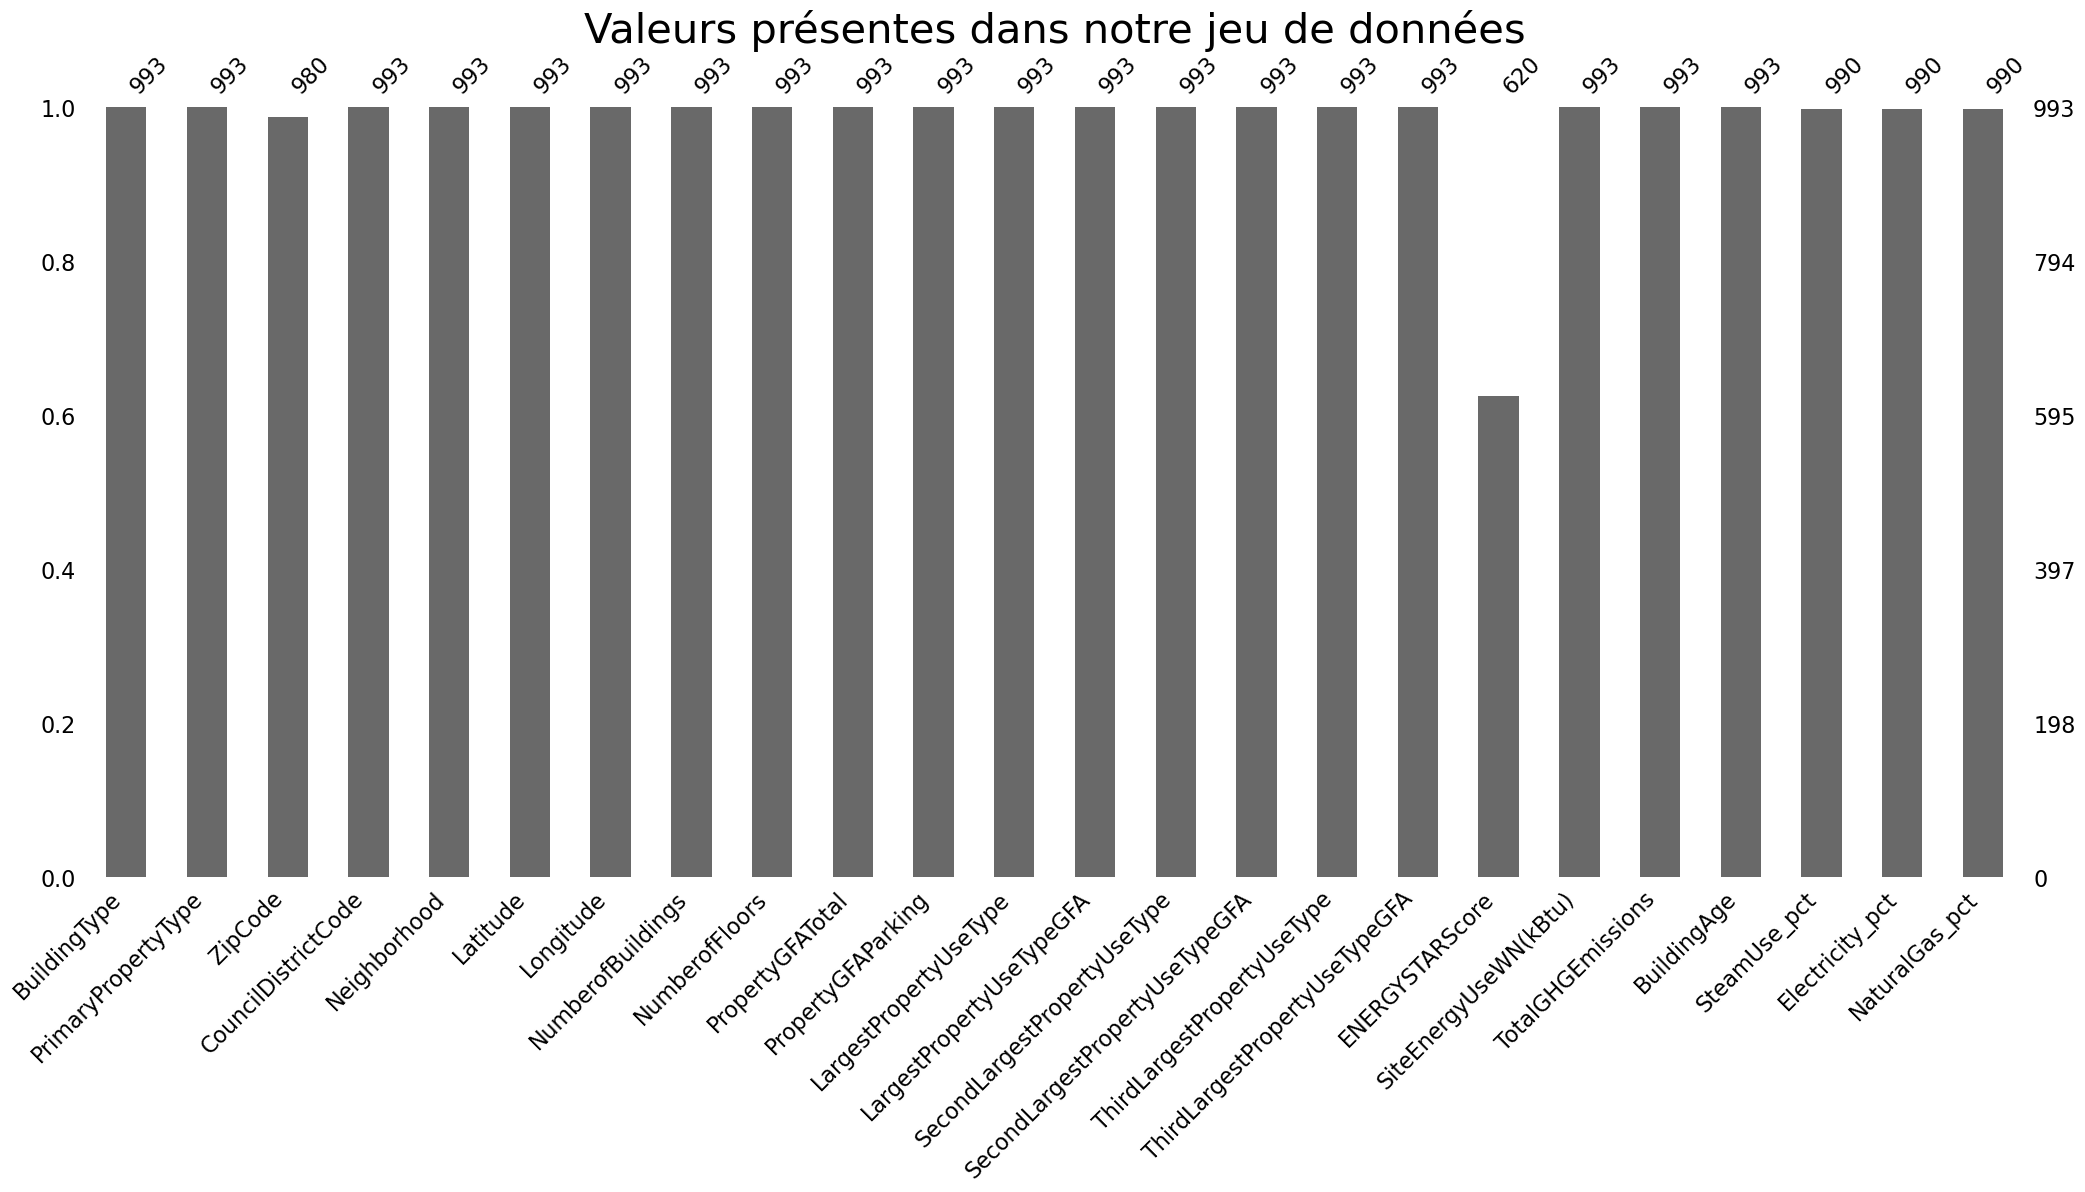

In [120]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_completed)

Les données manquantes sont celles de l'EnergyStarScore, comme nous voulons en étudier l'intérêt pour nos modèles nous allons conserver un dataframe avec l'energystarscore à part.

In [121]:
df_with_EnergyStarScore = df_completed.dropna()

In [122]:
df_with_EnergyStarScore.shape

(620, 24)

In [123]:
df = df_completed.drop(columns=['ENERGYSTARScore'])
df.shape

(993, 23)

# Analyse Exploratoire des Données

## Analyse Univariée

### Variables numériques

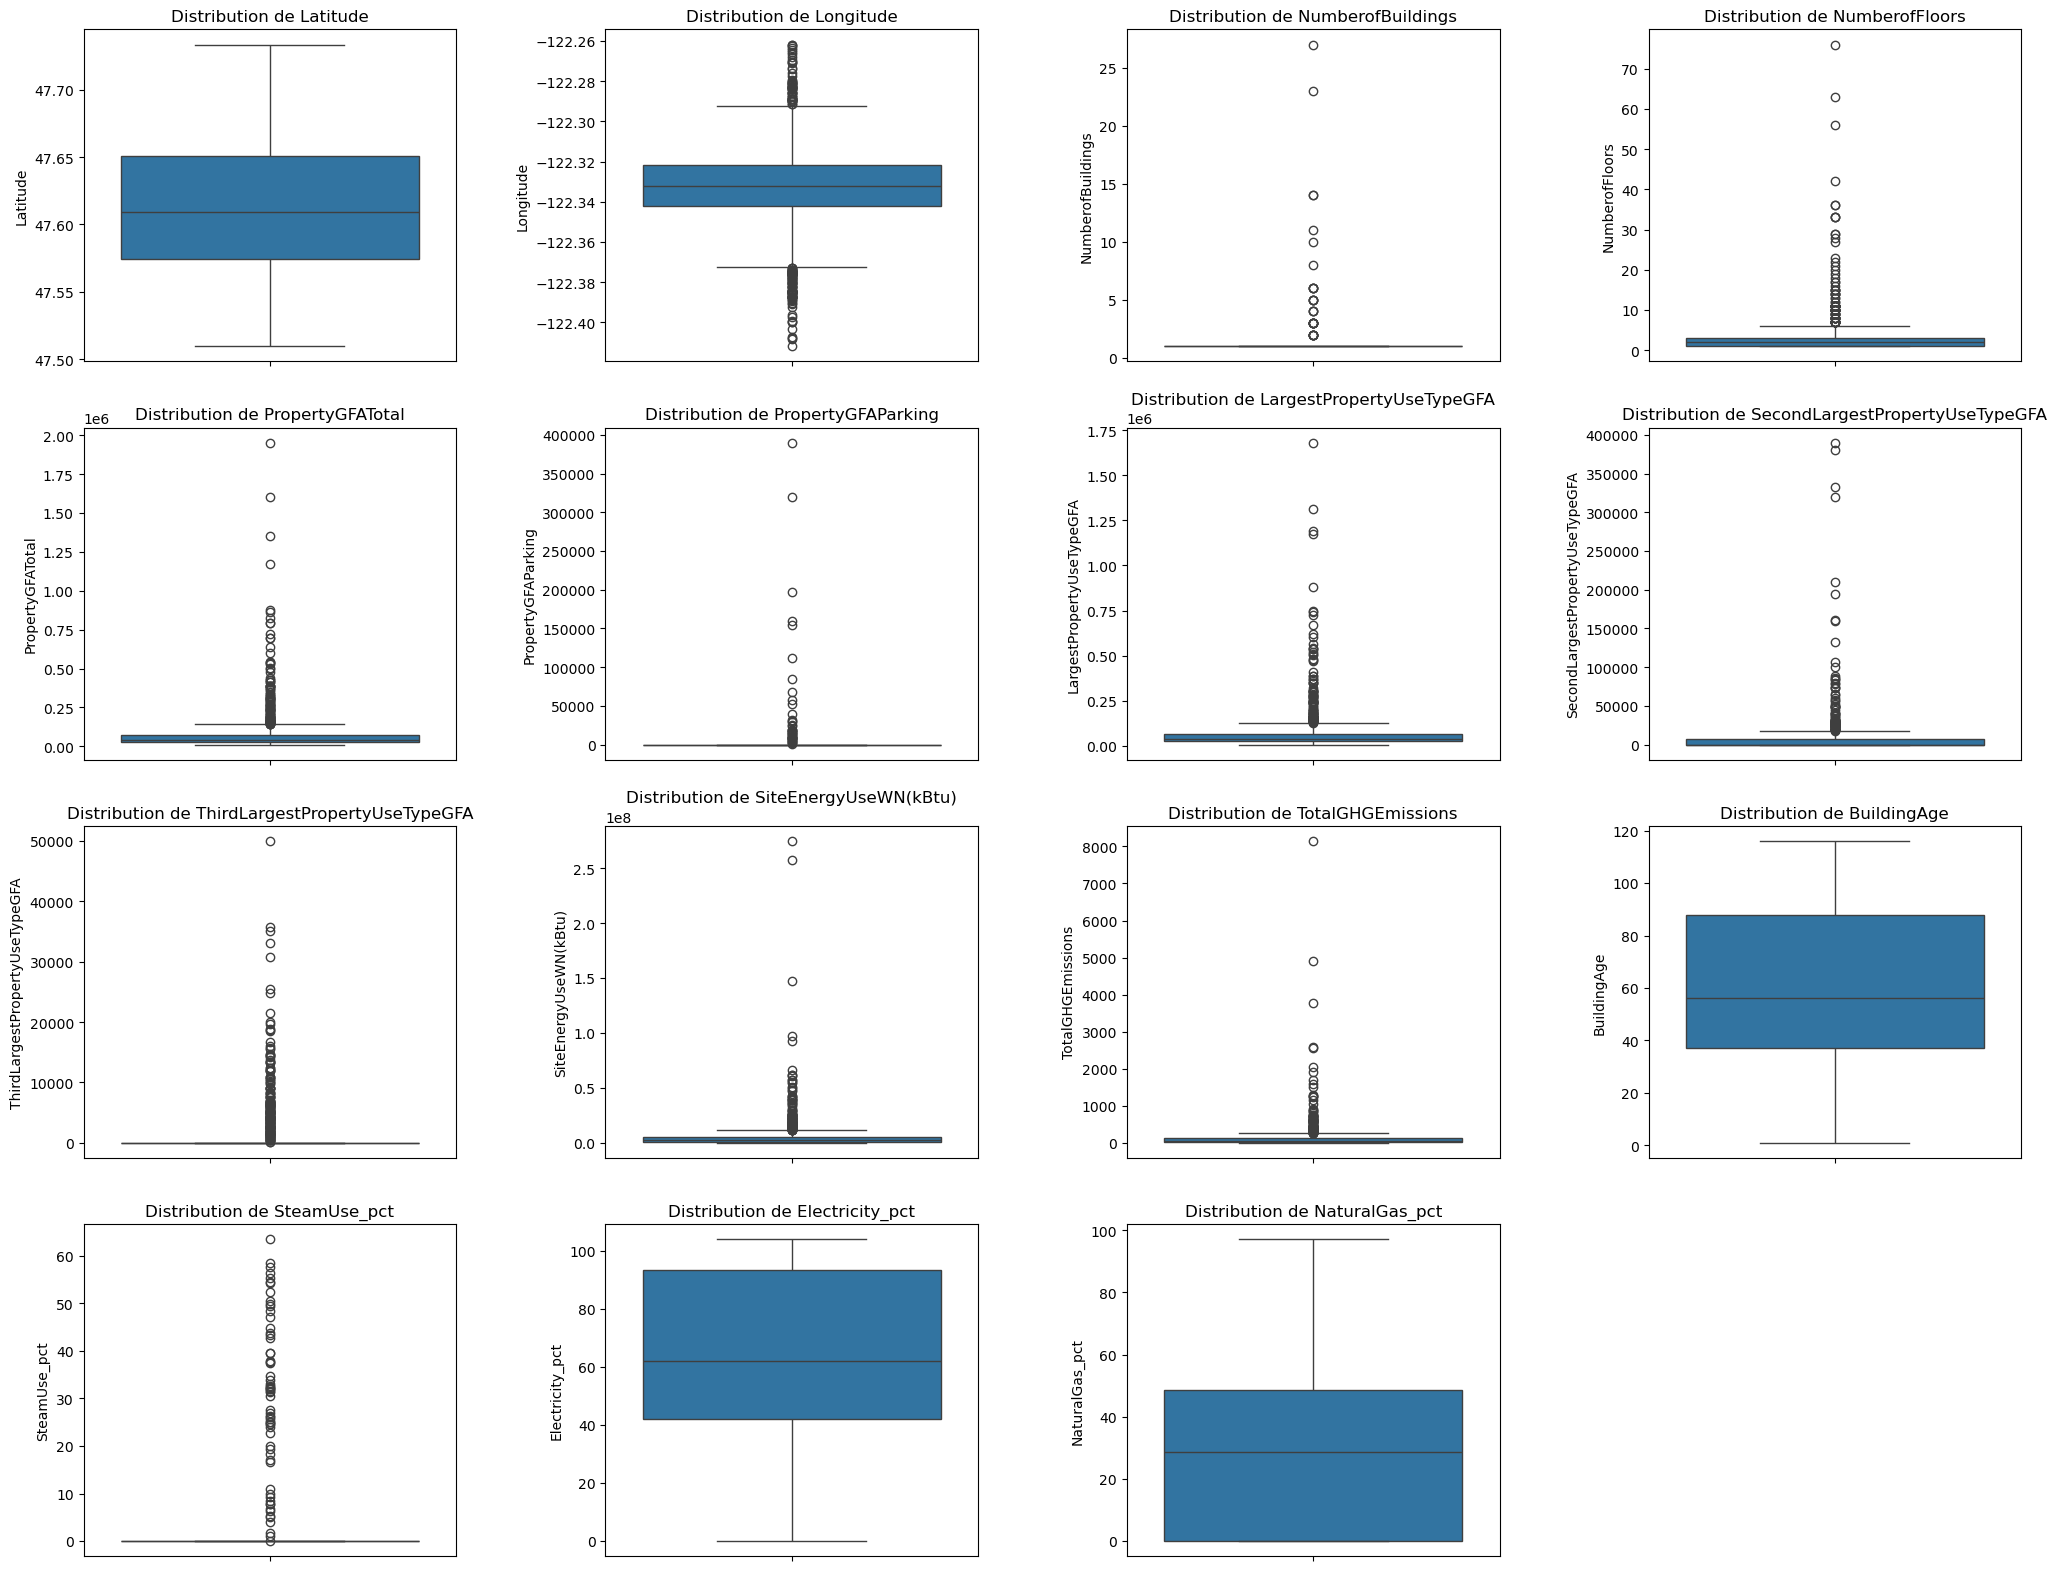

In [150]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df.select_dtypes(include=['number']).columns.drop(['ZipCode', 'CouncilDistrictCode'])

# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25,25))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 20):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [125]:
df.describe()

ZipCode  CouncilDistrictCode    Latitude   Longitude  \
count    980.000000           993.000000  993.000000  993.000000   
mean   98117.742857             4.063444   47.613341 -122.332977   
std       18.500951             2.181993    0.051170    0.024655   
min    98011.000000             1.000000   47.509590 -122.411820   
25%    98105.000000             2.000000   47.574600 -122.342270   
50%    98115.000000             4.000000   47.609250 -122.332380   
75%    98126.000000             7.000000   47.651150 -122.321930   
max    98199.000000             7.000000   47.733680 -122.261800   

       NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count         993.000000      993.000000      9.930000e+02   
mean            1.169184        3.315206      7.987222e+04   
std             1.394682        5.366633      1.391451e+05   
min             1.000000        1.000000      1.128500e+04   
25%             1.000000        1.000000      2.626300e+04   
50%             1.000000        2.000000      3.997100e+04   
75%             1.000000        3.000000      7.329600e+04   
max            27.000000       76.000000      1.952220e+06   

       PropertyGFAParking  LargestPropertyUseTypeGFA  \
count          993.000000               9.930000e+02   
mean          2046.572004               7.104761e+04   
std          19509.376809               1.238460e+05   
min              0.000000               6.601000e+03   
25%              0.000000               2.341900e+04   
50%              0.000000               3.569400e+04   
75%              0.000000               6.471200e+04   
max         389860.000000               1.680937e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                       993.000000                      993.000000   
mean                       7911.847432                     1296.562236   
std                       28051.189911                     4115.985877   
min                           0.000000                        0.000000   
25%                           0.000000                        0.000000   
50%                           0.000000                        0.000000   
75%                        7200.000000                        0.000000   
max                      389860.000000                    50000.000000   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  BuildingAge  SteamUse_pct  \
count           9.930000e+02         993.000000   993.000000    990.000000   
mean            6.055275e+06         132.982336    59.967774      1.893666   
std             1.571406e+07         392.750777    31.093722      8.420386   
min             0.000000e+00           0.000000     1.000000      0.000000   
25%             1.103795e+06          17.790000    37.000000      0.000000   
50%             2.158188e+06          43.170000    56.000000      0.000000   
75%             5.390148e+06         116.940000    88.000000      0.000000   
max             2.747260e+08        8145.520000   116.000000     63.453768   

       Electricity_pct  NaturalGas_pct  
count       990.000000      990.000000  
mean         64.188786       28.352671  
std          27.293268       24.202697  
min           0.000000        0.000000  
25%          41.925912        0.000000  
50%          61.920333       28.580267  
75%          93.470064       48.613085  
max         103.872233       97.077764

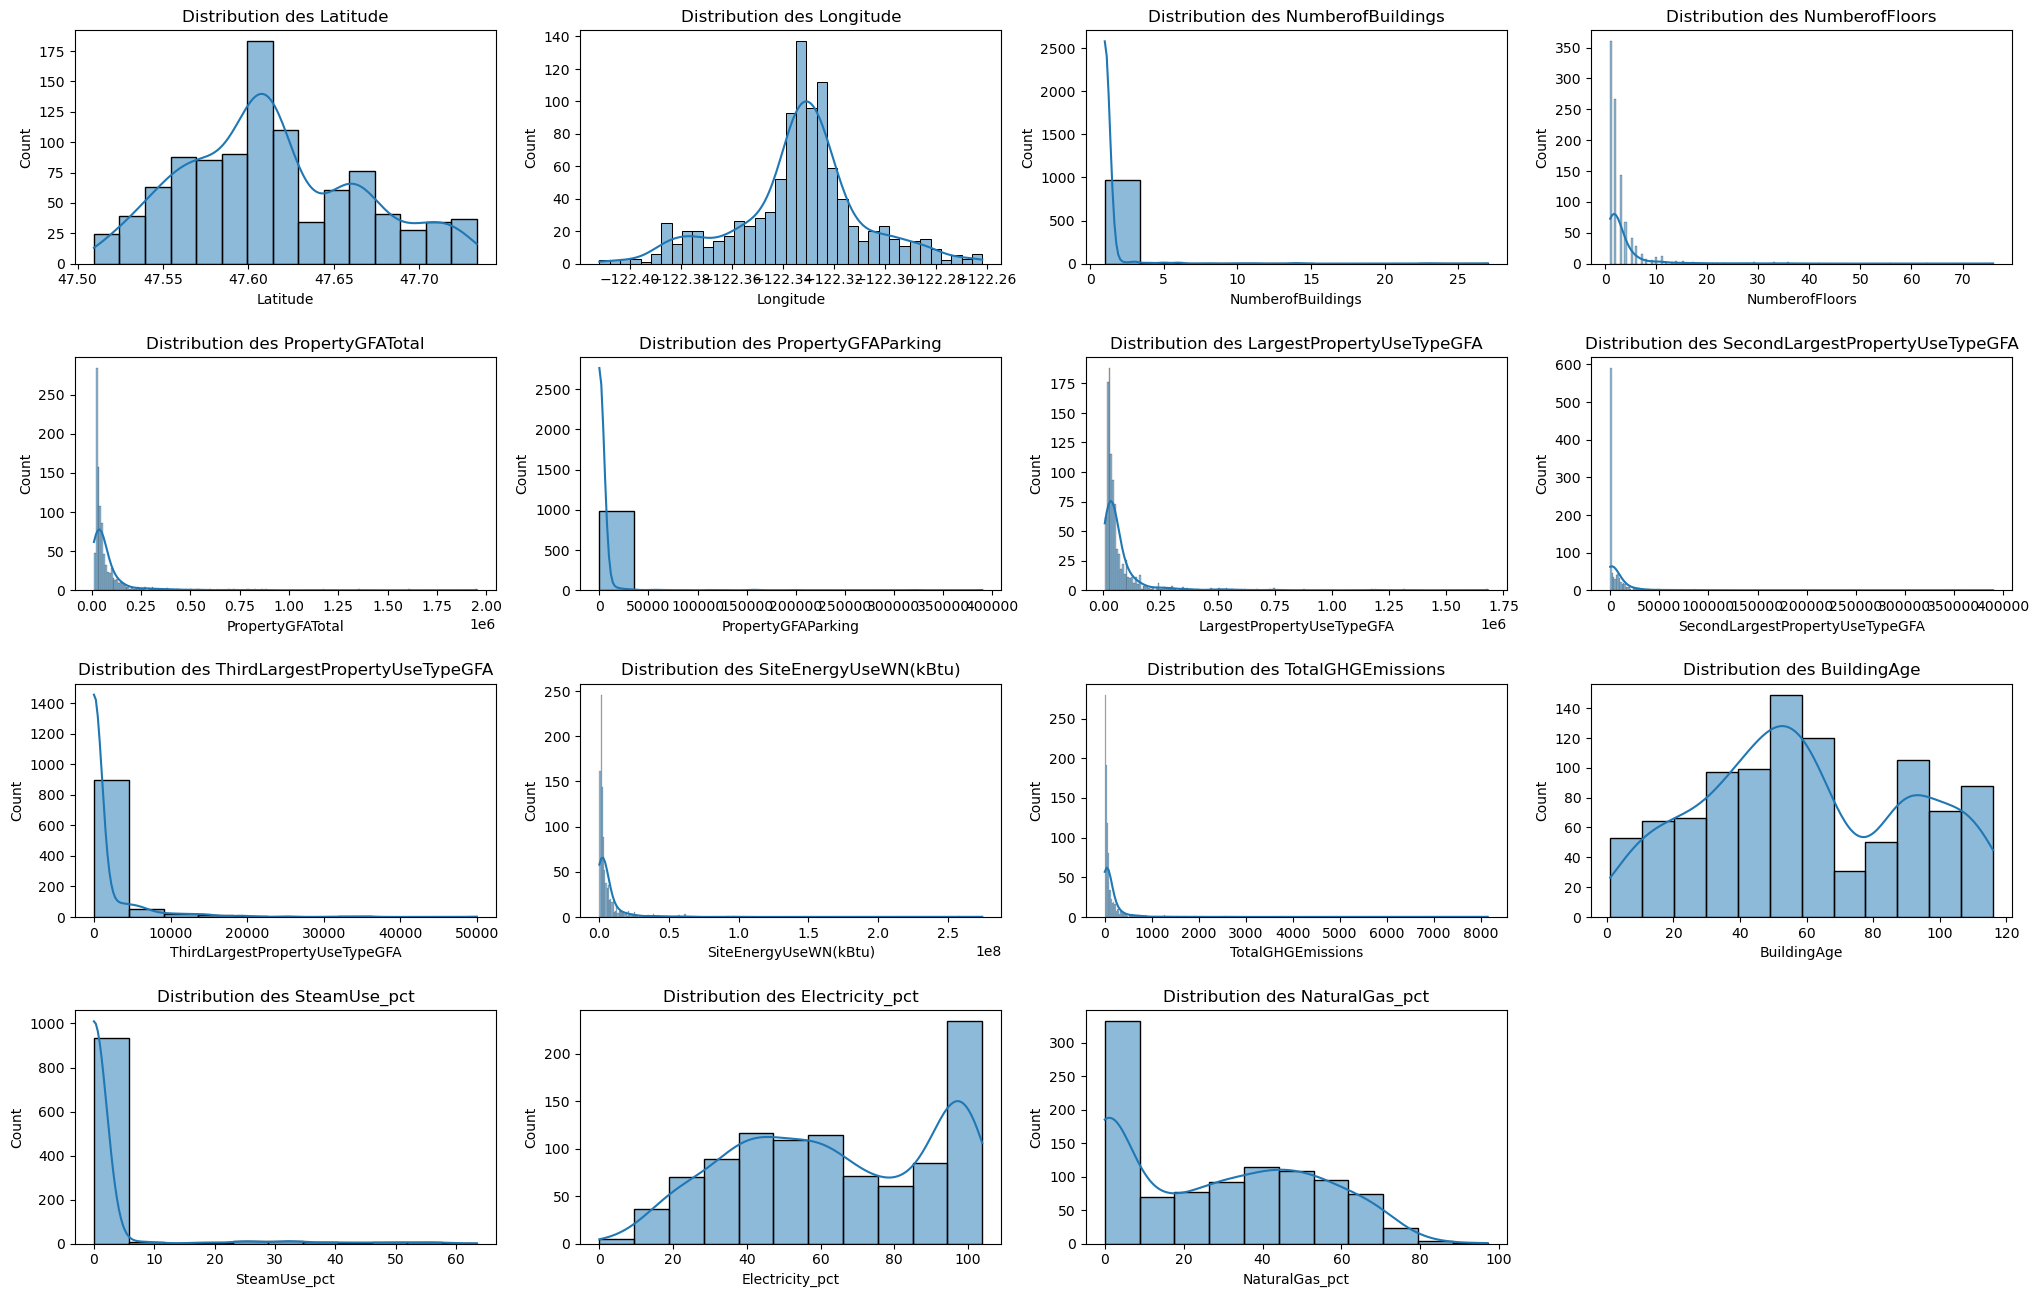

In [151]:
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25,20))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

# Density plot
for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.histplot(data=df, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution des {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 20):
    fig.delaxes(axes.flatten()[j])

plt.show()

### Variables catégorielles

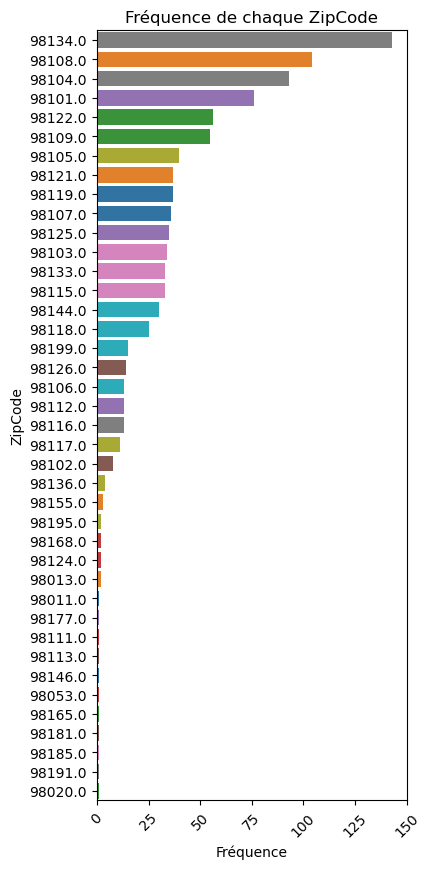

In [154]:
# ZipCode
group_counts = df['ZipCode'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='ZipCode', data=df, order=group_counts.index, hue='ZipCode', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque ZipCode')
plt.xlabel('Fréquence')
plt.ylabel('ZipCode')

plt.show()

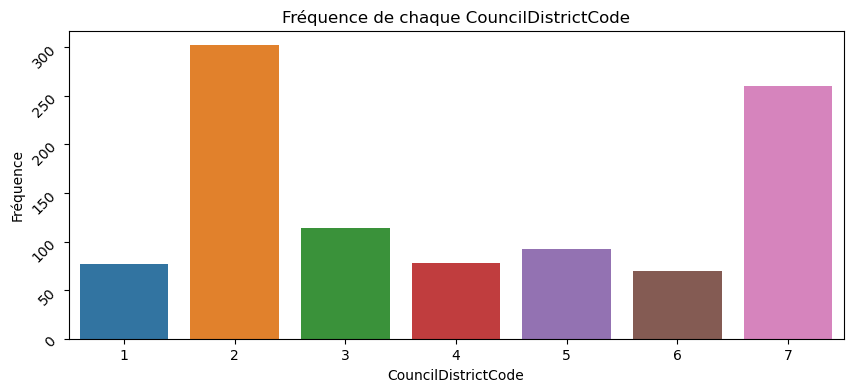

In [158]:
# Compter le nombre d'occurrences pour chaque CouncilDistrictCode
group_counts = df['CouncilDistrictCode'].value_counts().reset_index()
group_counts.columns = ['CouncilDistrictCode', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='CouncilDistrictCode', y='Counts', data=group_counts, hue='CouncilDistrictCode', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque CouncilDistrictCode')
plt.ylabel('Fréquence')
plt.xlabel('CouncilDistrictCode')

plt.show()

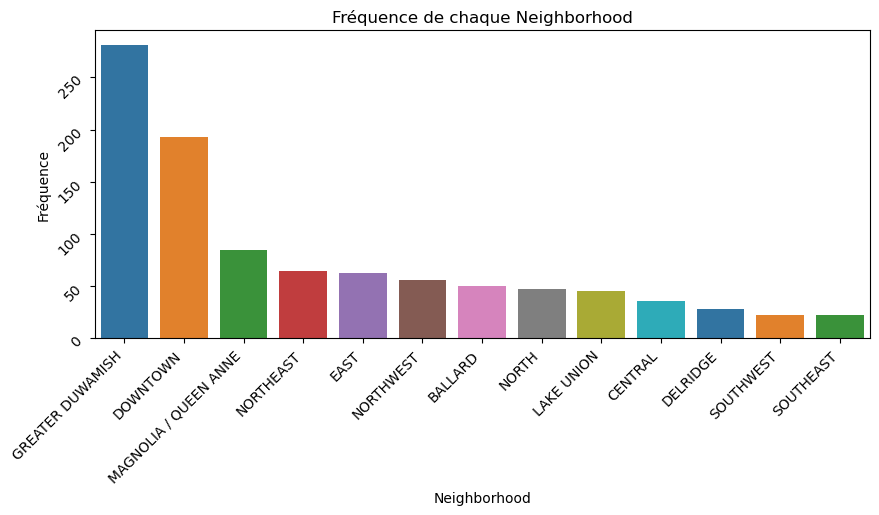

In [162]:
# Compter le nombre d'occurrences pour chaque Neighborhood
group_counts = df['Neighborhood'].value_counts().reset_index()
group_counts.columns = ['Neighborhood', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='Neighborhood', y='Counts', data=group_counts, hue='Neighborhood', palette="tab20", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque Neighborhood')
plt.ylabel('Fréquence')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha="right")

plt.show()

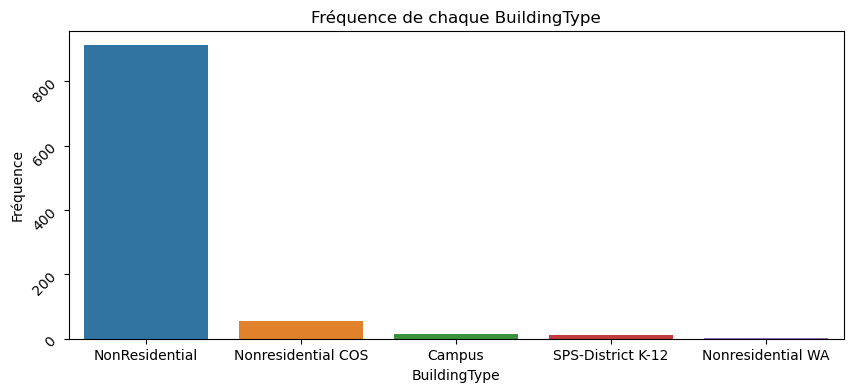

In [160]:
# Compter le nombre d'occurrences pour chaque BuildingType
group_counts = df['BuildingType'].value_counts().reset_index()
group_counts.columns = ['BuildingType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='BuildingType', y='Counts', data=group_counts, hue='BuildingType', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque BuildingType')
plt.ylabel('Fréquence')
plt.xlabel('BuildingType')

plt.show()

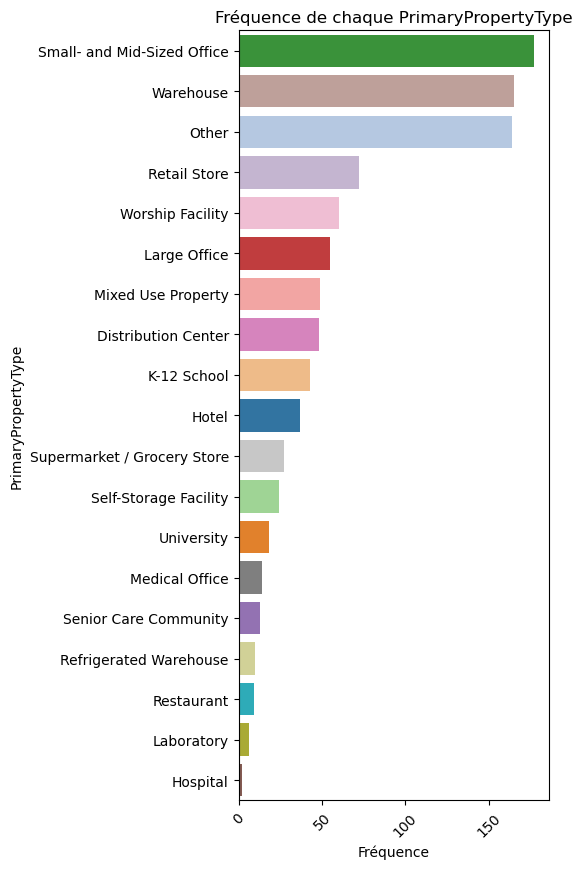

In [164]:
# PrimaryPropertyType
group_counts = df['PrimaryPropertyType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='PrimaryPropertyType', data=df, order=group_counts.index, hue='PrimaryPropertyType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque PrimaryPropertyType')
plt.xlabel('Fréquence')
plt.ylabel('PrimaryPropertyType')

plt.show()

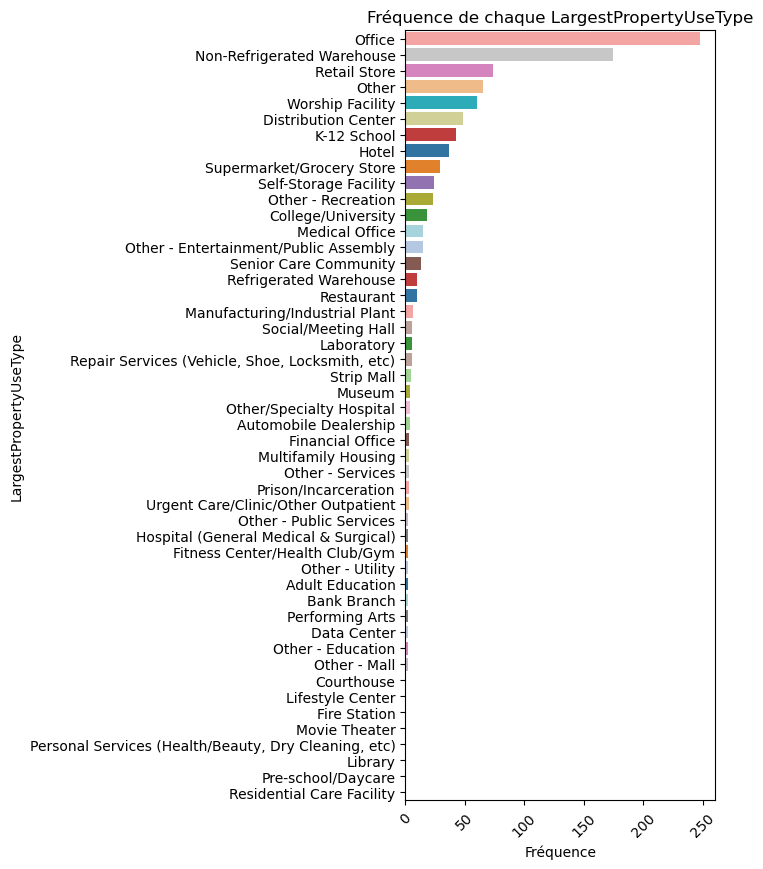

In [165]:
# LargestPropertyUseType
group_counts = df['LargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='LargestPropertyUseType', data=df, order=group_counts.index, hue='LargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque LargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('LargestPropertyUseType')

plt.show()

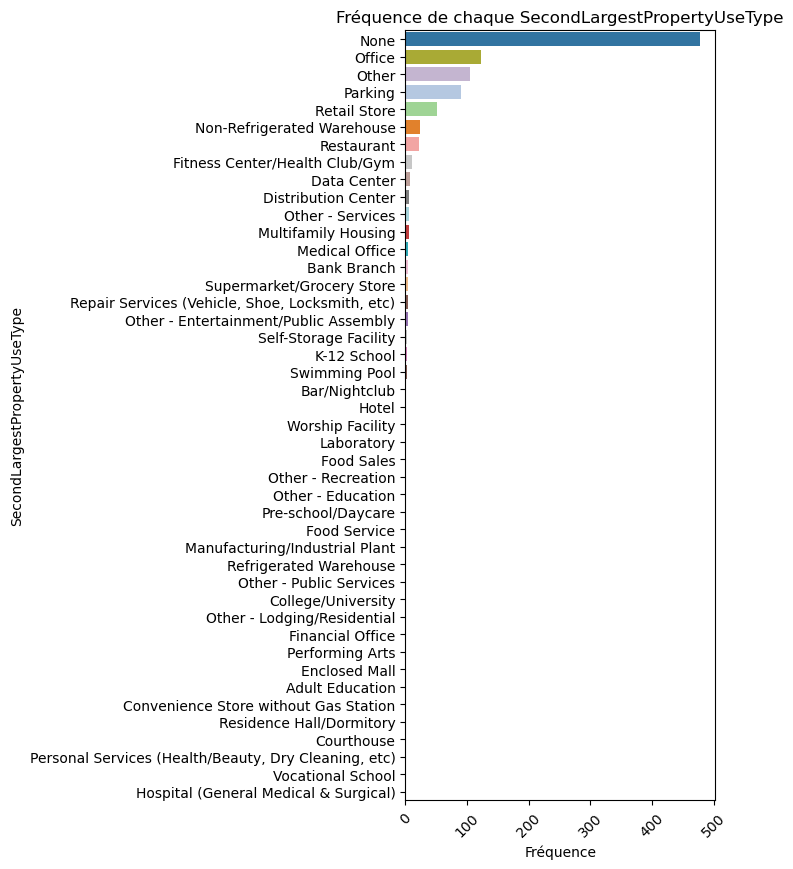

In [166]:
# SecondLargestPropertyUseType
group_counts = df['SecondLargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='SecondLargestPropertyUseType', data=df, order=group_counts.index, hue='SecondLargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque SecondLargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('SecondLargestPropertyUseType')

plt.show()

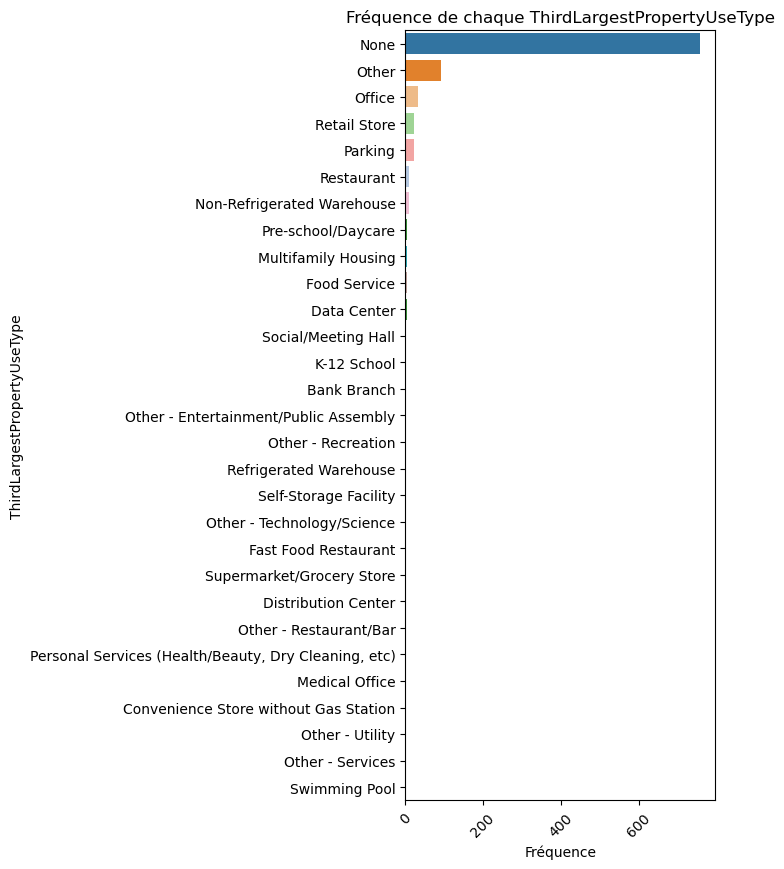

In [167]:
# ThirdLargestPropertyUseType
group_counts = df['ThirdLargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='ThirdLargestPropertyUseType', data=df, order=group_counts.index, hue='ThirdLargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque ThirdLargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('ThirdLargestPropertyUseType')

plt.show()

## Analyse Bivariée

In [170]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df.copy()

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df[numerics_col])

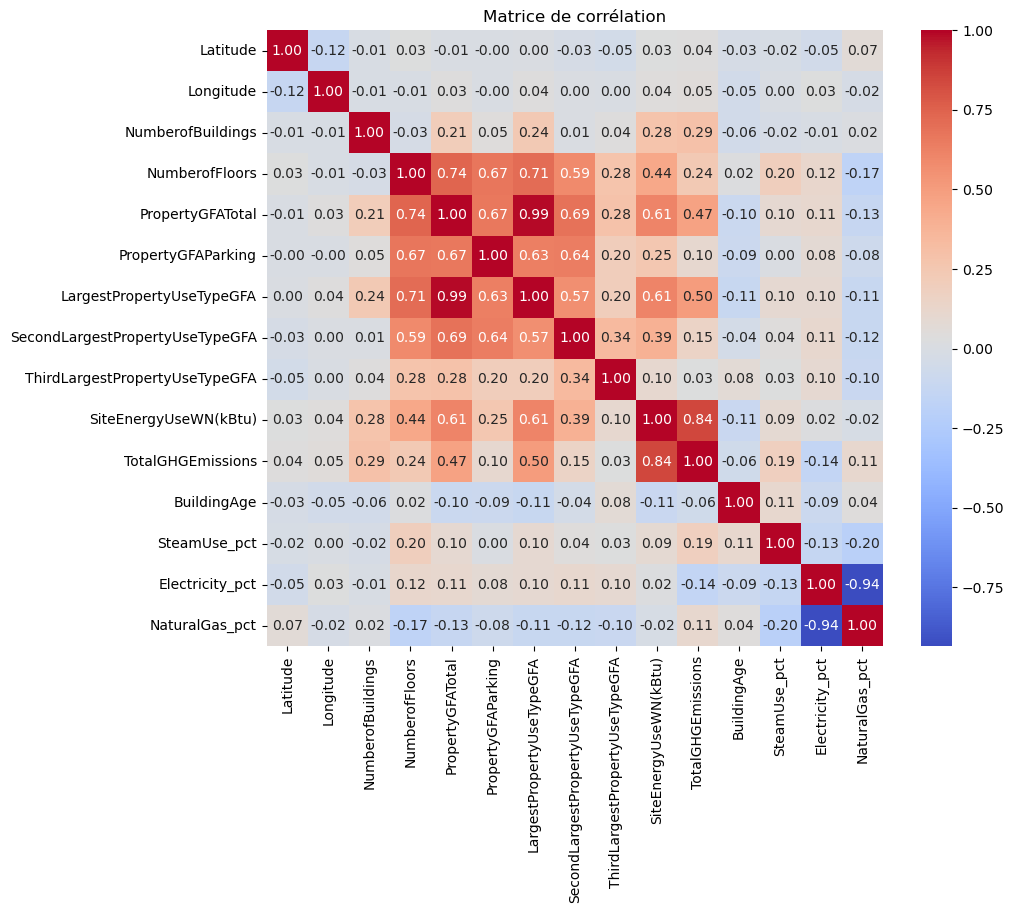

In [171]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

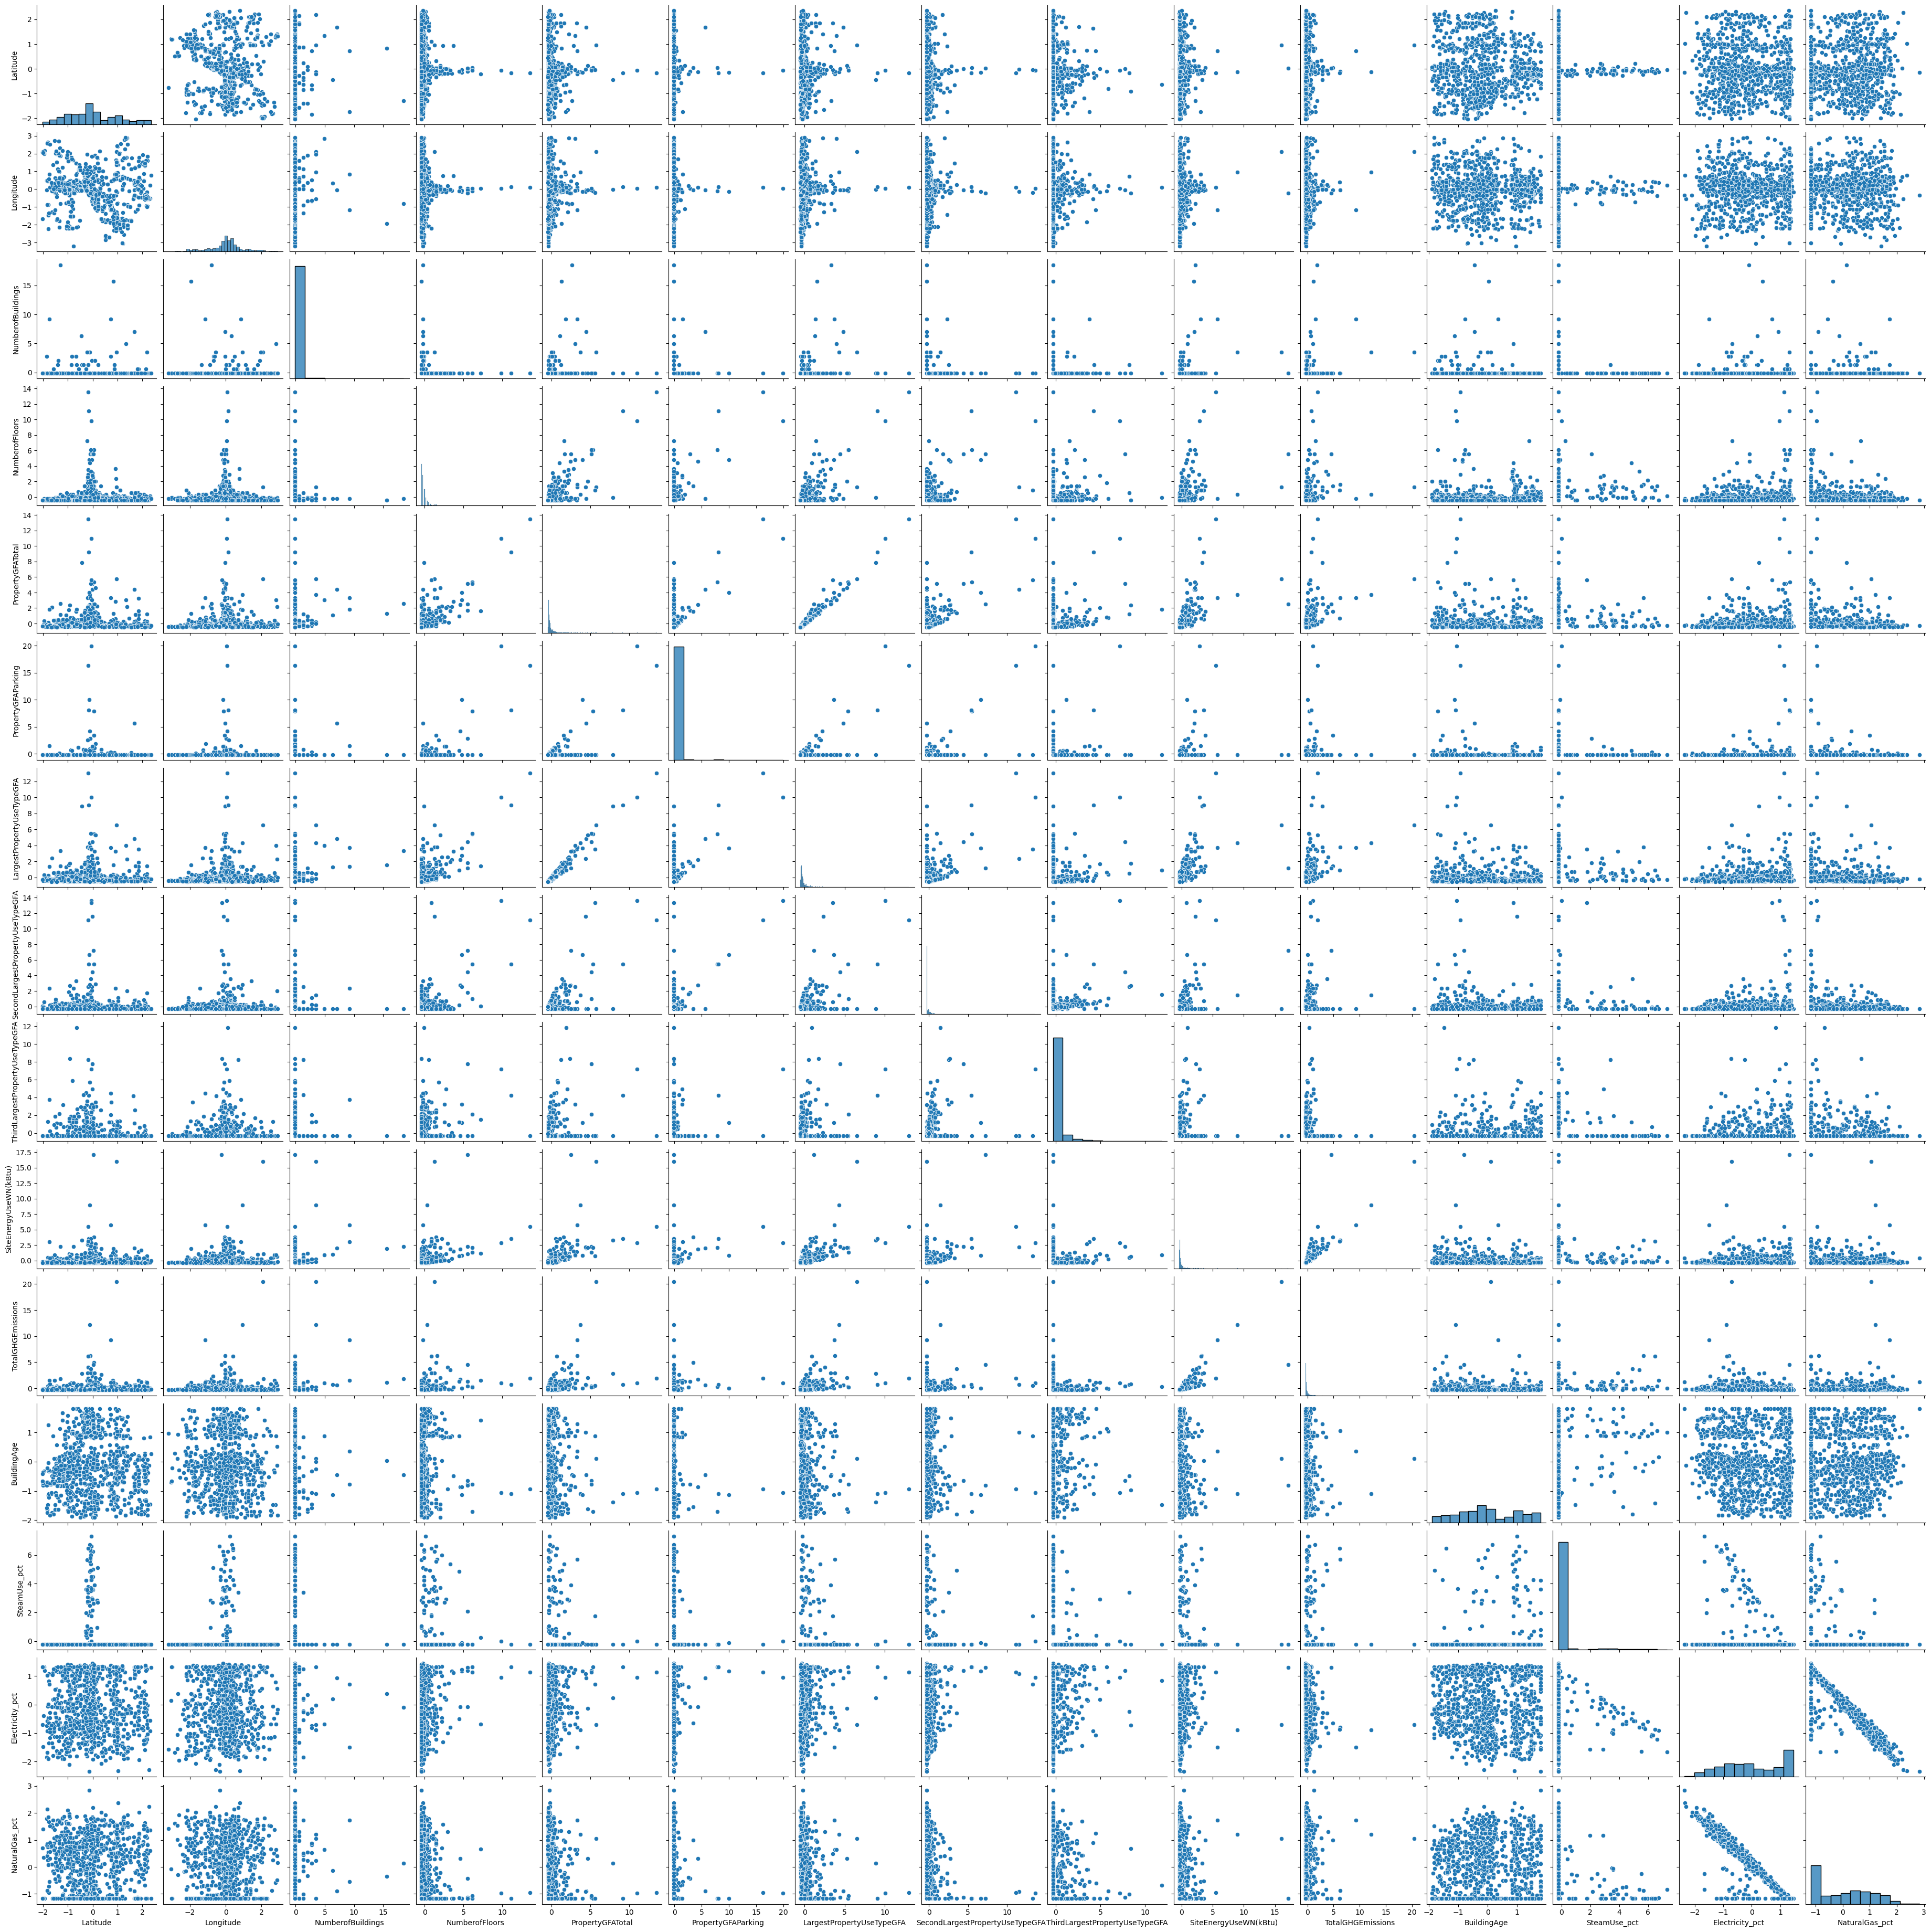

In [172]:
sns.pairplot(df_normalized[numerics_col])

plt.show()

## Analyse Multivariée

ANOVA

# Feature Engineering

## Passage au Log